# Pre-processing

Import orders_cust data

In [ ]:
import pandas as pd
import numpy as np

# Load the data
orders = pd.read_csv("orders_cust.csv")

Remove unwanted columns and rows based on date difference

In [ ]:
# Filter the orders
filtered_orders = orders[orders['Material'].astype(str).str.startswith('K') & ~orders['Material'].astype(str).str.startswith('KP')]

# Drop unnecessary columns
filtered_orders = filtered_orders.drop(columns=['D','Cl.','SPlt','Qty Requested.1','Setup','PO Quantity','Date','Fill Rate','Partial Fill Rate'])

# Convert dates to datetime
filtered_orders['Req.Date'] = pd.to_datetime(filtered_orders['Req.Date'])
filtered_orders['Deliv.dt'] = pd.to_datetime(filtered_orders['Deliv.dt'])

# Calculate date difference
filtered_orders['Date_Difference'] = (filtered_orders['Deliv.dt'] - filtered_orders['Req.Date']).dt.days

# Filter orders based on date difference
filtered_orders = filtered_orders[(filtered_orders['Date_Difference'] >= 0) & (filtered_orders['Date_Difference'] < 366)]

In [ ]:
filtered_orders['Material'].nunique() #checking total unique materials

1304

Dropping additional unwanted columns

In [ ]:
# Convert numeric columns
def convert_to_float(value):
    try:
        return float(value.replace(',', ''))
    except ValueError:
        return np.nan  # return NaN if the value cannot be converted

numeric_columns = ['Qty Requested']  # Add any other numeric columns as needed
for column in numeric_columns:
    filtered_orders[column] = filtered_orders[column].apply(convert_to_float).astype(float).astype(int)

# Drop additional unnecessary columns
filtered_orders = filtered_orders.drop(columns=['Item','Plnt','Deliv.dt','Release Dt','Date_Difference','PDT','IPT'])

In [ ]:
#Aggergate Qty Requested by Material anbd Req.Date
import pandas as pd

# Assuming filtered_orders is your DataFrame
# Group by 'Material' and 'Req.Date', and then sum the 'Qty Requested'
filtered_orders = filtered_orders.groupby(['Material', 'Req.Date'])['Qty Requested'].sum().reset_index()

Create Volume-CoV categorization

In [ ]:
# Group by Material and calculate volume percentage and overall CV
grouped_df = filtered_orders.groupby('Material')['Qty Requested'].agg(['sum', 'mean', 'std'])
grouped_df['std'] = grouped_df['std'].fillna(0)

# Calculate the volume percentage
total_volume = grouped_df['sum'].sum()
grouped_df['Volume %'] = (grouped_df['sum'] / total_volume) * 100

# Calculate CV based on last year data or overall data if last year data is not available
latest_date = filtered_orders['Req.Date'].max()
one_year_ago = latest_date - pd.Timedelta(days=365)

last_year_orders = filtered_orders[filtered_orders['Req.Date'] >= one_year_ago]
last_year_grouped = last_year_orders.groupby('Material')['Qty Requested'].agg(['mean', 'std'])
last_year_grouped['std'] = last_year_grouped['std'].fillna(0)

grouped_df['CV'] = last_year_grouped['std'] / last_year_grouped['mean']
grouped_df['CV'] = grouped_df['CV'].fillna(grouped_df['std'] / grouped_df['mean'])

Assigning segment category

In [ ]:
# Apply ranking
percentile_80 = grouped_df['sum'].quantile(0.8)
def rank_materials(row):
    if row['sum'] >= percentile_80:
        return 'Top 20%'
    else:
        return 'Below 80%'

grouped_df['Rank'] = grouped_df.apply(rank_materials, axis=1)

# Determine group based on CV and Rank
def determine_group(row):
    if row['CV'] <= 1:
        return 'Low Variance - High Volume' if row['Rank'] == 'Top 20%' else 'Low Variance - Low Volume'
    else:
        return 'High Variance - High Volume' if row['Rank'] == 'Top 20%' else 'High Variance - Low Volume'

grouped_df['Group'] = grouped_df.apply(determine_group, axis=1)


In [ ]:
# Merge the 'Group' column from 'grouped_df' into 'filtered_orders'
filtered_orders = filtered_orders.merge(grouped_df['Group'], on='Material', how='left')

filtered_orders.head()

Material   Req.Date  Qty Requested                        Group
0  K1053-8 2018-01-02              7  High Variance - High Volume
1  K1053-8 2018-01-03              1  High Variance - High Volume
2  K1053-8 2018-01-04              1  High Variance - High Volume
3  K1053-8 2018-01-08              1  High Variance - High Volume
4  K1053-8 2018-01-09              4  High Variance - High Volume

In [ ]:
print(filtered_orders.groupby('Group')['Material'].nunique())

KeyError: 'Group'

Filter low-variance and high-volume category

In [ ]:
hvo = filtered_orders[(filtered_orders['Group'] == 'Low Variance - High Volume') | (filtered_orders['Group'] == 'High Variance - High Volume')]



Material   Req.Date  Qty Requested                        Group
0       K1053-8 2018-01-02              7  High Variance - High Volume
1       K1053-8 2018-01-03              1  High Variance - High Volume
2       K1053-8 2018-01-04              1  High Variance - High Volume
3       K1053-8 2018-01-08              1  High Variance - High Volume
4       K1053-8 2018-01-09              4  High Variance - High Volume
...         ...        ...            ...                          ...
128936      K96 2023-11-02              1   Low Variance - High Volume
128937      K96 2023-11-06              3   Low Variance - High Volume
128938      K96 2023-11-07              3   Low Variance - High Volume
128939      K96 2023-11-24              1   Low Variance - High Volume
128940      K96 2023-12-05              2   Low Variance - High Volume

[94411 rows x 4 columns]

In [ ]:
hvo['Material'].nunique() #check number of materials in this category

261

Prepare pivot_df like a time-series for actual orders by material

In [ ]:
# Pivot table with Req.Date as index and unique Material as columns
pivot_df = hvo.pivot_table(index='Req.Date', columns='Material', values='Qty Requested', aggfunc='sum')

# Reset the index to make Req.Date a column again
pivot_df.reset_index(inplace=True)


Material   Req.Date  K1053-8  K1053-9  K1170  K1170-5  K1170-6  K1288-17  \
0        2017-06-05      NaN      NaN    NaN      NaN      NaN       NaN   
1        2017-09-21      NaN      NaN    NaN      NaN      NaN       NaN   
2        2017-09-25      NaN      NaN    NaN      NaN      NaN       NaN   
3        2017-11-15      NaN      NaN    NaN      NaN      NaN       NaN   
4        2017-11-16      NaN      NaN    NaN      NaN      NaN       NaN   
...             ...      ...      ...    ...      ...      ...       ...   
2101     2023-12-17      NaN      NaN    NaN      NaN      NaN       1.0   
2102     2023-12-18      NaN      NaN    NaN      NaN      NaN       NaN   
2103     2023-12-19      NaN      NaN    NaN      NaN      NaN       NaN   
2104     2023-12-20      NaN      NaN   96.0      NaN      NaN       NaN   
2105     2023-12-21      1.0      NaN    NaN      NaN      NaN       NaN   

Material  K1297  K1365-23  K1365-29  ...  K814  K852-25  K852-50  K852-70  \
0           NaN       NaN       NaN  ...   NaN      NaN      NaN      NaN   
1           NaN       NaN      10.0  ...   NaN      NaN      NaN      NaN   
2           NaN       NaN       NaN  ...   NaN      NaN      NaN      NaN   
3           NaN       NaN       NaN  ...   NaN      NaN      NaN      NaN   
4           NaN       NaN      10.0  ...   NaN      NaN      NaN      NaN   
...         ...       ...       ...  ...   ...      ...      ...      ...   
2101        NaN       NaN       NaN  ...   NaN      NaN      NaN      NaN   
2102       24.0       NaN       NaN  ...   NaN      NaN      NaN      NaN   
2103       12.0       NaN       NaN  ...   NaN      NaN      NaN      NaN   
2104        NaN       NaN       NaN  ...   NaN      NaN      NaN      NaN   
2105       24.0       NaN       NaN  ...   NaN      NaN      NaN      NaN   

Material  K852-95  K875  K909-6  K940-25  K940-75  K96  
0             NaN   NaN     NaN      NaN      NaN  NaN  
1             NaN   NaN     NaN      NaN      NaN  NaN  
2             NaN   NaN     NaN      NaN      NaN  NaN  
3             NaN   NaN     NaN      NaN      6.0  NaN  
4             NaN   NaN     NaN      NaN      2.0  NaN  
...           ...   ...     ...      ...      ...  ...  
2101          NaN   NaN     NaN      NaN      NaN  NaN  
2102          NaN   NaN     NaN      NaN      NaN  NaN  
2103          NaN   NaN     NaN      NaN      NaN  NaN  
2104          NaN   NaN     NaN      NaN      NaN  NaN  
2105          NaN   NaN     NaN      NaN      NaN  NaN  

[2106 rows x 262 columns]

In [ ]:
# Count the number of NaNs in each column
nan_count_per_column = pivot_df.isna().sum()

# Calculate the average number of NaNs across all columns
average_nan = nan_count_per_column.mean()



Number of NaNs in each column:
 Material
Req.Date       0
K1053-8     1488
K1053-9     1621
K1170       1098
K1170-5     2073
            ... 
K875        2025
K909-6      1855
K940-25     1659
K940-75     1944
K96         1690
Length: 262, dtype: int64

Average number of NaNs across all columns: 1737.6145038167938


In [ ]:
# Replace NaN values with 0
pivot_df = pivot_df.fillna(0)



Material   Req.Date  K1053-8  K1053-9  K1170  K1170-5  K1170-6  K1288-17  \
0        2017-06-05      0.0      0.0    0.0      0.0      0.0       0.0   
1        2017-09-21      0.0      0.0    0.0      0.0      0.0       0.0   
2        2017-09-25      0.0      0.0    0.0      0.0      0.0       0.0   
3        2017-11-15      0.0      0.0    0.0      0.0      0.0       0.0   
4        2017-11-16      0.0      0.0    0.0      0.0      0.0       0.0   
...             ...      ...      ...    ...      ...      ...       ...   
2101     2023-12-17      0.0      0.0    0.0      0.0      0.0       1.0   
2102     2023-12-18      0.0      0.0    0.0      0.0      0.0       0.0   
2103     2023-12-19      0.0      0.0    0.0      0.0      0.0       0.0   
2104     2023-12-20      0.0      0.0   96.0      0.0      0.0       0.0   
2105     2023-12-21      1.0      0.0    0.0      0.0      0.0       0.0   

Material  K1297  K1365-23  K1365-29  ...  K814  K852-25  K852-50  K852-70  \
0           0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1           0.0       0.0      10.0  ...   0.0      0.0      0.0      0.0   
2           0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
3           0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
4           0.0       0.0      10.0  ...   0.0      0.0      0.0      0.0   
...         ...       ...       ...  ...   ...      ...      ...      ...   
2101        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2102       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2103       12.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2104        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2105       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   

Material  K852-95  K875  K909-6  K940-25  K940-75  K96  
0             0.0   0.0     0.0      0.0      0.0  0.0  
1             0.0   0.0     0.0      0.0      0.0  0.0  
2             0.0   0.0     0.0      0.0      0.0  0.0  
3             0.0   0.0     0.0      0.0      6.0  0.0  
4             0.0   0.0     0.0      0.0      2.0  0.0  
...           ...   ...     ...      ...      ...  ...  
2101          0.0   0.0     0.0      0.0      0.0  0.0  
2102          0.0   0.0     0.0      0.0      0.0  0.0  
2103          0.0   0.0     0.0      0.0      0.0  0.0  
2104          0.0   0.0     0.0      0.0      0.0  0.0  
2105          0.0   0.0     0.0      0.0      0.0  0.0  

[2106 rows x 262 columns]

Consider the dates from 2021 to 2023 for forecast

In [ ]:
# Filter pivot_df for dates on or after January 1, 2022
pivot_df = pivot_df[pivot_df['Req.Date'] >= pd.Timestamp('2021-01-01')]



Material   Req.Date  K1053-8  K1053-9  K1170  K1170-5  K1170-6  K1288-17  \
1065     2021-01-01      0.0      0.0   96.0      0.0      0.0       0.0   
1066     2021-01-02      0.0      0.0    0.0      0.0      0.0       6.0   
1067     2021-01-04      0.0      2.0   12.0      0.0      0.0       0.0   
1068     2021-01-05      1.0      2.0   96.0      0.0      0.0       0.0   
1069     2021-01-06      0.0      0.0  108.0      0.0      0.0       0.0   
...             ...      ...      ...    ...      ...      ...       ...   
2101     2023-12-17      0.0      0.0    0.0      0.0      0.0       1.0   
2102     2023-12-18      0.0      0.0    0.0      0.0      0.0       0.0   
2103     2023-12-19      0.0      0.0    0.0      0.0      0.0       0.0   
2104     2023-12-20      0.0      0.0   96.0      0.0      0.0       0.0   
2105     2023-12-21      1.0      0.0    0.0      0.0      0.0       0.0   

Material  K1297  K1365-23  K1365-29  ...  K814  K852-25  K852-50  K852-70  \
1065        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1066        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1067       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1068       48.0       0.0       0.0  ...   0.0      0.0      0.0     50.0   
1069       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
...         ...       ...       ...  ...   ...      ...      ...      ...   
2101        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2102       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2103       12.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2104        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2105       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   

Material  K852-95  K875  K909-6  K940-25  K940-75  K96  
1065          0.0   0.0     0.0      0.0      0.0  0.0  
1066          0.0   0.0     0.0      0.0      0.0  0.0  
1067          0.0   0.0     0.0     10.0      0.0  0.0  
1068          0.0   0.0     0.0      0.0      0.0  1.0  
1069          0.0   0.0     0.0      0.0      0.0  0.0  
...           ...   ...     ...      ...      ...  ...  
2101          0.0   0.0     0.0      0.0      0.0  0.0  
2102          0.0   0.0     0.0      0.0      0.0  0.0  
2103          0.0   0.0     0.0      0.0      0.0  0.0  
2104          0.0   0.0     0.0      0.0      0.0  0.0  
2105          0.0   0.0     0.0      0.0      0.0  0.0  

[1041 rows x 262 columns]

In [ ]:
# Sort the DataFrame in ascending order of Req.Date
pivot_df = pivot_df.sort_values(by='Req.Date', ascending=True)


Material   Req.Date  K1053-8  K1053-9  K1170  K1170-5  K1170-6  K1288-17  \
1065     2021-01-01      0.0      0.0   96.0      0.0      0.0       0.0   
1066     2021-01-02      0.0      0.0    0.0      0.0      0.0       6.0   
1067     2021-01-04      0.0      2.0   12.0      0.0      0.0       0.0   
1068     2021-01-05      1.0      2.0   96.0      0.0      0.0       0.0   
1069     2021-01-06      0.0      0.0  108.0      0.0      0.0       0.0   
...             ...      ...      ...    ...      ...      ...       ...   
2101     2023-12-17      0.0      0.0    0.0      0.0      0.0       1.0   
2102     2023-12-18      0.0      0.0    0.0      0.0      0.0       0.0   
2103     2023-12-19      0.0      0.0    0.0      0.0      0.0       0.0   
2104     2023-12-20      0.0      0.0   96.0      0.0      0.0       0.0   
2105     2023-12-21      1.0      0.0    0.0      0.0      0.0       0.0   

Material  K1297  K1365-23  K1365-29  ...  K814  K852-25  K852-50  K852-70  \
1065        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1066        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1067       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
1068       48.0       0.0       0.0  ...   0.0      0.0      0.0     50.0   
1069       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
...         ...       ...       ...  ...   ...      ...      ...      ...   
2101        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2102       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2103       12.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2104        0.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   
2105       24.0       0.0       0.0  ...   0.0      0.0      0.0      0.0   

Material  K852-95  K875  K909-6  K940-25  K940-75  K96  
1065          0.0   0.0     0.0      0.0      0.0  0.0  
1066          0.0   0.0     0.0      0.0      0.0  0.0  
1067          0.0   0.0     0.0     10.0      0.0  0.0  
1068          0.0   0.0     0.0      0.0      0.0  1.0  
1069          0.0   0.0     0.0      0.0      0.0  0.0  
...           ...   ...     ...      ...      ...  ...  
2101          0.0   0.0     0.0      0.0      0.0  0.0  
2102          0.0   0.0     0.0      0.0      0.0  0.0  
2103          0.0   0.0     0.0      0.0      0.0  0.0  
2104          0.0   0.0     0.0      0.0      0.0  0.0  
2105          0.0   0.0     0.0      0.0      0.0  0.0  

[1041 rows x 262 columns]

In [ ]:
#ensuring continous dates
import pandas as pd

# Ensure 'Req.Date' is in datetime format
pivot_df['Req.Date'] = pd.to_datetime(pivot_df['Req.Date'])

# Find min and max dates in the 'Req.Date' column
min_date = pivot_df['Req.Date'].min()
max_date = pivot_df['Req.Date'].max()

# Create a DataFrame with a continuous date range from min_date to max_date
all_dates_df = pd.DataFrame({'Req.Date': pd.date_range(start=min_date, end=max_date)})

# Merge the all_dates_df with the original pivot_df to include missing dates
# Use an outer join to ensure that all dates are included
pivot_df = pd.merge(all_dates_df, pivot_df, on='Req.Date', how='left')

# Fill NaN values with 0 for all material columns
material_columns = pivot_df.columns[1:]  # Assuming the rest of the columns are material columns
pivot_df[material_columns] = pivot_df[material_columns].fillna(0)


Req.Date  K1053-8  K1053-9  K1170  K1170-5  K1170-6  K1288-17  K1297  \
0    2021-01-01      0.0      0.0   96.0      0.0      0.0       0.0    0.0   
1    2021-01-02      0.0      0.0    0.0      0.0      0.0       6.0    0.0   
2    2021-01-03      0.0      0.0    0.0      0.0      0.0       0.0    0.0   
3    2021-01-04      0.0      2.0   12.0      0.0      0.0       0.0   24.0   
4    2021-01-05      1.0      2.0   96.0      0.0      0.0       0.0   48.0   
...         ...      ...      ...    ...      ...      ...       ...    ...   
1080 2023-12-17      0.0      0.0    0.0      0.0      0.0       1.0    0.0   
1081 2023-12-18      0.0      0.0    0.0      0.0      0.0       0.0   24.0   
1082 2023-12-19      0.0      0.0    0.0      0.0      0.0       0.0   12.0   
1083 2023-12-20      0.0      0.0   96.0      0.0      0.0       0.0    0.0   
1084 2023-12-21      1.0      0.0    0.0      0.0      0.0       0.0   24.0   

      K1365-23  K1365-29  ...  K814  K852-25  K852-50  K852-70  K852-95  K875  \
0          0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
1          0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
2          0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
3          0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
4          0.0       0.0  ...   0.0      0.0      0.0     50.0      0.0   0.0   
...        ...       ...  ...   ...      ...      ...      ...      ...   ...   
1080       0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
1081       0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
1082       0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
1083       0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   
1084       0.0       0.0  ...   0.0      0.0      0.0      0.0      0.0   0.0   

      K909-6  K940-25  K940-75  K96  
0        0.0      0.0      0.0  0.0  
1        0.0      0.0      0.0  0.0  
2        0.0      0.0      0.0  0.0  
3        0.0     10.0      0.0  0.0  
4        0.0      0.0      0.0  1.0  
...      ...      ...      ...  ...  
1080     0.0      0.0      0.0  0.0  
1081     0.0      0.0      0.0  0.0  
1082     0.0      0.0      0.0  0.0  
1083     0.0      0.0      0.0  0.0  
1084     0.0      0.0      0.0  0.0  

[1085 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming pivot_df is already defined and includes a 'Req.Date' column

# Create a copy of pivot_df to preserve the original DataFrame
pivot_df_copy = pivot_df.copy()

# Convert 'Req.Date' to datetime format if not already
pivot_df_copy['Req.Date'] = pd.to_datetime(pivot_df_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
pivot_df_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
pivot_df_monthly = pivot_df_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
pivot_df_monthly.reset_index(inplace=True)

# pivot_df_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original pivot_df
#pivot_df_monthly


Req.Date  K1053-8  K1053-9   K1170  K1170-5  K1170-6  K1288-17  K1297  \
0  2021-01-01     19.0      6.0  1680.0      0.0      0.0      19.0  384.0   
1  2021-02-01     47.0     31.0  1848.0      0.0      0.0      13.0  372.0   
2  2021-03-01     34.0      6.0  2760.0      0.0      0.0      76.0  480.0   
3  2021-04-01     21.0     11.0  2532.0      0.0      0.0       5.0  612.0   
4  2021-05-01     28.0      8.0  2160.0      0.0      0.0      11.0  312.0   
5  2021-06-01     14.0     23.0  2364.0     36.0      0.0       6.0  504.0   
6  2021-07-01     14.0      9.0  1776.0     24.0      0.0       2.0  240.0   
7  2021-08-01      4.0     10.0  1308.0     24.0      0.0       7.0  276.0   
8  2021-09-01     20.0     13.0  1596.0      0.0      0.0      13.0  300.0   
9  2021-10-01     18.0      2.0  1320.0      0.0      0.0       6.0  276.0   
10 2021-11-01     21.0     13.0  1968.0     12.0      0.0       9.0  264.0   
11 2021-12-01      8.0     10.0  1512.0      0.0      0.0      10.0  396.0   
12 2022-01-01     12.0      5.0  1440.0      0.0      0.0      25.0  300.0   
13 2022-02-01      8.0      5.0   576.0      0.0      0.0       2.0  252.0   
14 2022-03-01     14.0      9.0   612.0      0.0      0.0      15.0  168.0   
15 2022-04-01     19.0     30.0   888.0     12.0      0.0      39.0  192.0   
16 2022-05-01     22.0      7.0  1728.0      0.0      0.0      15.0  228.0   
17 2022-06-01     20.0     13.0  1632.0      0.0      0.0      17.0  192.0   
18 2022-07-01     15.0     23.0   984.0      0.0      0.0      13.0  156.0   
19 2022-08-01     13.0      9.0   924.0      0.0      0.0       9.0  180.0   
20 2022-09-01     26.0      5.0   504.0      0.0      0.0      17.0  240.0   
21 2022-10-01      3.0      1.0  1152.0      0.0      0.0      55.0  288.0   
22 2022-11-01     12.0      5.0   888.0      0.0      0.0      15.0  228.0   
23 2022-12-01     24.0      6.0   972.0      0.0      0.0      45.0  240.0   
24 2023-01-01     18.0      3.0  1008.0     12.0      0.0       6.0  276.0   
25 2023-02-01     12.0      7.0   876.0      0.0      0.0       9.0  168.0   
26 2023-03-01     49.0     10.0   996.0      0.0      0.0      10.0  252.0   
27 2023-04-01     15.0      9.0   780.0      0.0      0.0      36.0  252.0   
28 2023-05-01     24.0      9.0   748.0      0.0      0.0      13.0  192.0   
29 2023-06-01     19.0     15.0   324.0      0.0      0.0      30.0  168.0   
30 2023-07-01     20.0      2.0   708.0      0.0      0.0      19.0  180.0   
31 2023-08-01      9.0      7.0   732.0     12.0      0.0      17.0  156.0   
32 2023-09-01      8.0      5.0   600.0      0.0      0.0      11.0  216.0   
33 2023-10-01      6.0      5.0   792.0     72.0      0.0      15.0  216.0   
34 2023-11-01      9.0      6.0   696.0     12.0      0.0      18.0  228.0   
35 2023-12-01      5.0     19.0   516.0      0.0      0.0       2.0  168.0   

    K1365-23  K1365-29  ...   K814  K852-25  K852-50  K852-70  K852-95  K875  \
0        9.0       0.0  ...   48.0     12.0     21.0    100.0     76.0  34.0   
1       30.0      35.0  ...   72.0     24.0      0.0    100.0    138.0   0.0   
2       41.0      42.0  ...   48.0     15.0      0.0     50.0     38.0  17.0   
3        9.0      81.0  ...   72.0     24.0     16.0    150.0    114.0  51.0   
4        2.0       0.0  ...  172.0     36.0      6.0     50.0     38.0  17.0   
5       15.0       0.0  ...   96.0     44.0      6.0    170.0     76.0   0.0   
6       17.0      10.0  ...   48.0     12.0      6.0    100.0     38.0  17.0   
7        3.0      26.0  ...   72.0      0.0      6.0    100.0     76.0  17.0   
8       21.0       0.0  ...    0.0      0.0     48.0    130.0     76.0  40.0   
9       26.0       0.0  ...    0.0     39.0      0.0     50.0     38.0  30.0   
10       6.0       0.0  ...    0.0     12.0      0.0    300.0     76.0  20.0   
11       0.0      35.0  ...    0.0      0.0      0.0    150.0     38.0  17.0   
12      33.0       0.0  ...   24.0     12.0     22.0    100.0     76.0  17.0  

In [ ]:
#saving actual df to csv
#pivot_df.to_csv("actual_df.csv", index=False)
#pivot_df_monthly.to_csv("actual_df_monthly.csv")

# Data Preparation Stage

Adding weekday and month cyclic features

In [ ]:
import numpy as np

# Extract week and month from Req.Date
pivot_df['Week'] = pivot_df['Req.Date'].dt.isocalendar().week
pivot_df['Month'] = pivot_df['Req.Date'].dt.month

# Number of weeks in a year and months in a year
num_weeks = 52
num_months = 12

# Apply sine and cosine transformations for week and month
pivot_df['Week_Sin'] = np.sin(2 * np.pi * pivot_df['Week'] / num_weeks)
pivot_df['Week_Cos'] = np.cos(2 * np.pi * pivot_df['Week'] / num_weeks)
pivot_df['Month_Sin'] = np.sin(2 * np.pi * (pivot_df['Month'] - 1) / num_months)
pivot_df['Month_Cos'] = np.cos(2 * np.pi * (pivot_df['Month'] - 1) / num_months)

# Select all material columns along with Req.Date, Week, Month, and cyclic feature columns
selected_columns = ['Req.Date', 'Week', 'Week_Sin', 'Week_Cos', 'Month', 'Month_Sin', 'Month_Cos'] + [col for col in pivot_df.columns if col not in ['Req.Date', 'Week', 'Month', 'Week_Sin', 'Week_Cos', 'Month_Sin', 'Month_Cos']]

# Output the DataFrame with new cyclic features
#pivot_df[selected_columns]
#pivot_df


/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4171482518.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df['Week'] = pivot_df['Req.Date'].dt.isocalendar().week
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4171482518.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df['Month'] = pivot_df['Req.Date'].dt.month
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4171482518.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

Req.Date  K1053-8  K1053-9  K1170  K1170-5  K1170-6  K1288-17  K1297  \
0    2021-01-01      0.0      0.0   96.0      0.0      0.0       0.0    0.0   
1    2021-01-02      0.0      0.0    0.0      0.0      0.0       6.0    0.0   
2    2021-01-03      0.0      0.0    0.0      0.0      0.0       0.0    0.0   
3    2021-01-04      0.0      2.0   12.0      0.0      0.0       0.0   24.0   
4    2021-01-05      1.0      2.0   96.0      0.0      0.0       0.0   48.0   
...         ...      ...      ...    ...      ...      ...       ...    ...   
1080 2023-12-17      0.0      0.0    0.0      0.0      0.0       1.0    0.0   
1081 2023-12-18      0.0      0.0    0.0      0.0      0.0       0.0   24.0   
1082 2023-12-19      0.0      0.0    0.0      0.0      0.0       0.0   12.0   
1083 2023-12-20      0.0      0.0   96.0      0.0      0.0       0.0    0.0   
1084 2023-12-21      1.0      0.0    0.0      0.0      0.0       0.0   24.0   

      K1365-23  K1365-29  ...  K909-6  K940-25  K940-75  K96  Week  Month  \
0          0.0       0.0  ...     0.0      0.0      0.0  0.0    53      1   
1          0.0       0.0  ...     0.0      0.0      0.0  0.0    53      1   
2          0.0       0.0  ...     0.0      0.0      0.0  0.0    53      1   
3          0.0       0.0  ...     0.0     10.0      0.0  0.0     1      1   
4          0.0       0.0  ...     0.0      0.0      0.0  1.0     1      1   
...        ...       ...  ...     ...      ...      ...  ...   ...    ...   
1080       0.0       0.0  ...     0.0      0.0      0.0  0.0    50     12   
1081       0.0       0.0  ...     0.0      0.0      0.0  0.0    51     12   
1082       0.0       0.0  ...     0.0      0.0      0.0  0.0    51     12   
1083       0.0       0.0  ...     0.0      0.0      0.0  0.0    51     12   
1084       0.0       0.0  ...     0.0      0.0      0.0  0.0    51     12   

      Week_Sin  Week_Cos  Month_Sin  Month_Cos  
0     0.120537  0.992709        0.0   1.000000  
1     0.120537  0.992709        0.0   1.000000  
2     0.120537  0.992709        0.0   1.000000  
3     0.120537  0.992709        0.0   1.000000  
4     0.120537  0.992709        0.0   1.000000  
...        ...       ...        ...        ...  
1080 -0.239316  0.970942       -0.5   0.866025  
1081 -0.120537  0.992709       -0.5   0.866025  
1082 -0.120537  0.992709       -0.5   0.866025  
1083 -0.120537  0.992709       -0.5   0.866025  
1084 -0.120537  0.992709       -0.5   0.866025  

[1085 rows x 268 columns]

Prepare training and validation data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Add, Activation, Multiply, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Assuming 'pivot_df' includes 'Req.Date', 'Week', 'Month', cyclic features ('Week_Sin', 'Week_Cos', 'Month_Sin', 'Month_Cos'), and Qty Requested columns

# Normalize the data including cyclic features but exclude 'Req.Date', 'Week', and 'Month'
columns_to_scale = [col for col in pivot_df.columns if col not in ['Req.Date', 'Week', 'Month']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pivot_df[columns_to_scale].values)

# Updated create_sequences to include cyclic features in each sequence
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length), :]
        y = data[i+seq_length, :-4]  # Assuming the last 4 columns are cyclic features and we exclude them from y
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 365  # Length of the sequence used to predict the next time step
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and validation sets
train_size = len(X) - 90 #assuming last 3 months for validation
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

# Reshape input for models to include cyclic features
input_shape = (X_train.shape[1], X_train.shape[2])
#X_val


array([[[0.04347826, 0.        , 0.14285714, ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0.        , 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0.        , 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ],
        ...,
        [0.        , 0.        , 0.14285714, ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0.04347826, 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0.        , 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ]],

       [[0.        , 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0.        , 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0.        , 0.03846154, 0.        , ..., 0.5       ,
         0.0669873 , 0.25      ],
        ...,
        [0.04347826, 0.        , 0.        , ..., 0.43973166,
         0.0669873 , 0.25      ],
        [0. 

# Modelling

## Model 1/4: Building CNN model

1/4 Update CNN model architecture and define MCDropout




In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# MCDropout definition
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# CNN Model with Monte Carlo Dropout
def build_cnn_model(input_shape, num_outputs):
    model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu'),
        MCDropout(0.2),
        Flatten(),
        Dense(200, activation='relu'),
        MCDropout(0.3),
        Dense(num_outputs, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='mean_squared_error')
    return model

2/4 Generate Predictions with uncertainity estimations

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_cnn = build_cnn_model(input_shape, y_train.shape[1])
model_cnn.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=10)])

num_samples = 100
predictions_cnn = np.array([model_cnn(X_val, training=True) for _ in range(num_samples)])

Epoch 1/200
20/20 [==============================] - 4s 185ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 2/200
20/20 [==============================] - 4s 183ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 3/200
20/20 [==============================] - 3s 175ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 4/200
20/20 [==============================] - 3s 164ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 5/200
20/20 [==============================] - 4s 181ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 6/200
20/20 [==============================] - 3s 167ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 7/200
20/20 [==============================] - 3s 166ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 8/200
20/20 [==============================] - 3s 167ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 9/200
20/20 [==============================] - 3s 168ms/step - loss: 0.0069 - val_loss: 0.0054
Epoch 10/200
20/20 [==============================] - 4s 176ms/step - loss: 0.0069 - val_lo

3/4 Rescale Predictions and Prepare DataFrame

In [ ]:
mean_predictions_cnn = np.mean(predictions_cnn, axis=0)
#max_predictions_cnn = np.max(predictions_cnn, axis=0)
std_dev_predictions_cnn = np.std(predictions_cnn, axis=0)

# Append dummy cyclic features for inverse transformation
dummy_cyclic = np.zeros((mean_predictions_cnn.shape[0], 4))
mean_predictions_cnn_with_dummy = np.hstack([mean_predictions_cnn, dummy_cyclic])
std_dev_predictions_cnn_with_dummy = np.hstack([std_dev_predictions_cnn, dummy_cyclic])

# Inverse transform
mean_rescaled_cnn = np.clip(scaler.inverse_transform(mean_predictions_cnn_with_dummy)[:, :-4], 0, None)
std_dev_rescaled_cnn = scaler.inverse_transform(std_dev_predictions_cnn_with_dummy)[:, :-4]

4/4 Update Dataframes with Req. Date

In [ ]:
validation_dates = pivot_df['Req.Date'].iloc[-90:].reset_index(drop=True)

mean_df_cnn = pd.DataFrame(mean_rescaled_cnn, columns=pivot_df.columns[1:-6])
mean_df_cnn.insert(0, 'Req.Date', validation_dates)

std_dev_df_cnn = pd.DataFrame(std_dev_rescaled_cnn, columns=pivot_df.columns[1:-6])
std_dev_df_cnn.insert(0, 'Req.Date', validation_dates)

In [ ]:
#mean_df_cnn.head()

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0 2023-09-23  0.431236  0.278888  13.984217  0.069239  0.000000  0.556412   
1 2023-09-24  0.443420  0.300429  12.224569  0.084570  0.000000  0.618451   
2 2023-09-25  0.615690  0.569700  23.217485  0.189673  0.000000  0.910222   
3 2023-09-26  0.727849  0.558846  36.518814  0.309542  0.000000  0.942762   
4 2023-09-27  0.652262  0.342972  32.605134  0.064089  0.000069  0.594344   

      K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0  4.128988  0.084503  0.000000  ...  0.786432  0.264791  0.195806  1.690583   
1  4.414254  0.011852  0.072158  ...  0.934825  0.257286  0.269075  1.233454   
2  6.625143  0.411098  0.045966  ...  1.303622  0.320724  0.443616  2.020585   
3  8.203102  0.829367  0.010253  ...  1.523790  0.458989  0.520371  3.860937   
4  7.578482  0.485162  0.232692  ...  1.065441  0.407222  0.445189  3.756982   

    K852-95      K875     K909-6   K940-25   K940-75       K96  
0  1.483944  0.317791  12.791068  0.967341  0.118768  0.254249  
1  1.122916  0.216690  13.880908  0.953436  0.136167  0.247884  
2  1.742157  0.488046  27.074772  2.265009  0.075025  0.364727  
3  2.717744  0.690622  32.817643  3.076681  0.072561  0.448879  
4  2.328654  0.452636  25.050699  2.476265  0.184373  0.393760  

[5 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming mean_df_cnn is already defined and includes a 'Req.Date' column

# Create a copy of mean_df_cnn to preserve the original DataFrame
mean_df_cnn_copy = mean_df_cnn.copy()

# Convert 'Req.Date' to datetime format if not already
mean_df_cnn_copy['Req.Date'] = pd.to_datetime(mean_df_cnn_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
mean_df_cnn_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
mean_df_cnn_monthly = mean_df_cnn_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
mean_df_cnn_monthly.reset_index(inplace=True)

# mean_df_cnn_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original mean_df_cnn
#mean_df_cnn_monthly


Req.Date    K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-09-01   4.475156  3.283498  178.145064  0.991972  0.001959   5.821925   
1 2023-10-01  17.734458  8.672487  729.812291  3.205111  0.021726  20.289809   
2 2023-11-01  16.825135  8.605906  767.206720  2.511808  0.011134  19.165669   
3 2023-12-01  11.650765  6.026272  561.318206  1.359218  0.015708  13.398095   

        K1297   K1365-23  K1365-29  ...       K814    K852-25    K852-50  \
0   47.423239   2.368065  0.954937  ...   7.956817   2.755483   3.023169   
1  196.737881   8.410595  3.543743  ...  38.741605  11.812331  11.933319   
2  195.979669  11.429198  4.593429  ...  36.430322  10.874216  13.836202   
3  132.512953   8.150041  3.417880  ...  24.393137   8.291081   9.351644   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0  17.605867  14.944391   2.896370  174.300248  14.264222  0.937177  2.712663  
1  80.783769  49.804412  13.705182  645.605550  58.861106  4.458781  8.834718  
2  87.972279  56.327670  12.820251  650.629072  57.046971  5.433877  9.360812  
3  67.192900  43.296940  11.192942  472.500324  43.212580  3.261240  6.337022  

[4 rows x 262 columns]

In [ ]:
#std_dev_df_cnn.head()

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0 2023-09-23  0.008954  0.041117   2.340736  0.024511  0.000406  0.070166   
1 2023-09-24  0.017953  0.023246   1.030032  0.040814  0.000603  0.043796   
2 2023-09-25  0.124448  0.258951   7.661704  0.281306  0.004169  0.321707   
3 2023-09-26  0.165306  0.402060  13.261824  0.448763  0.005996  0.565849   
4 2023-09-27  0.160870  0.267357   9.353655  0.376867  0.005499  0.398415   

      K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0  0.174857  0.081989  0.097359  ...  0.134028  0.015652  0.069390  0.499639   
1  0.249152  0.029489  0.018888  ...  0.088526  0.010449  0.049555  0.163724   
2  1.492659  0.209436  0.199646  ...  0.516858  0.120264  0.336080  1.502676   
3  2.241605  0.382899  0.355062  ...  0.763211  0.192604  0.451808  2.479779   
4  1.647916  0.269909  0.374759  ...  0.827198  0.209886  0.412983  2.112293   

    K852-95      K875     K909-6   K940-25   K940-75       K96  
0  0.327660  0.099459   1.254436  0.062864  0.019306  0.009621  
1  0.087479  0.028241   0.832063  0.070855  0.022260  0.011082  
2  0.651650  0.244285   7.832790  0.504721  0.180043  0.084036  
3  1.246597  0.441510  11.180780  0.669905  0.296329  0.142059  
4  1.201567  0.344505   8.810924  0.606610  0.183647  0.112125  

[5 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming std_dev_df_cnn is already defined and includes a 'Req.Date' column

# Create a copy of std_dev_df_cnn to preserve the original DataFrame
std_dev_df_cnn_copy = std_dev_df_cnn.copy()

# Convert 'Req.Date' to datetime format if not already
std_dev_df_cnn_copy['Req.Date'] = pd.to_datetime(std_dev_df_cnn_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
std_dev_df_cnn_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
std_dev_df_cnn_monthly = std_dev_df_cnn_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
std_dev_df_cnn_monthly.reset_index(inplace=True)

# std_dev_df_cnn_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original std_dev_df_cnn
#std_dev_df_cnn_monthly


Req.Date   K1053-8   K1053-9       K1170   K1170-5   K1170-6  K1288-17  \
0 2023-09-01  0.718291  1.364621   47.884899  1.707075  0.024725  1.908272   
1 2023-10-01  3.364472  4.428501  193.177798  7.400612  0.109213  7.873446   
2 2023-11-01  3.305464  4.281526  198.303129  7.672076  0.113247  8.456067   
3 2023-12-01  2.272407  3.563770  152.772735  5.477162  0.079619  5.873652   

       K1297  K1365-23  K1365-29  ...       K814   K852-25   K852-50  \
0   8.347261  1.371287  1.481546  ...   3.470824  0.890642  1.791993   
1  36.320087  6.298648  7.631496  ...  15.413624  3.832545  7.935474   
2  37.334866  6.240484  7.545437  ...  16.572994  4.061594  8.196836   
3  25.948361  4.644654  5.962359  ...  11.694741  3.052569  5.586315   

     K852-70    K852-95      K875      K909-6    K940-25   K940-75       K96  
0   9.191830   4.898702  1.597761   41.100263   2.901710  1.013872  0.534419  
1  40.626534  21.376567  6.904896  158.317969  11.555824  3.966341  2.170539  
2  41.945599  21.291479  6.979318  161.713115  11.990966  4.163883  2.249994  
3  30.347292  16.926667  5.423202  123.021564   9.079406  2.995281  1.613398  

[4 rows x 262 columns]

## Model 2/4: CNN classification + Prediction

Step 1: Build the Classification and Forecasting Models with Monte Carlo Dropout

In [ ]:
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Layer

# MCDropout definition
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

# Classification Model
def build_classification_model_cnn_comb(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu')(input_layer)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = MCDropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Forecasting Model
def build_forecasting_model_cnn_comb(input_shape, num_outputs):
    model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        MCDropout(0.1),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(256, 3, activation='relu'),
        MCDropout(0.1),
        Flatten(),
        Dense(256, activation='relu'),
        MCDropout(0.4),
        Dense(num_outputs, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='mean_squared_error')
    return model

##
y_train_class = (y_train.sum(axis=1) > 0).astype(int)
y_val_class = (y_val.sum(axis=1) > 0).astype(int)

# Assume X_train, y_train_class, y_train, X_val, y_val_class, y_val are already defined
input_shape = X_train.shape[1:]
cnn_comb_model_order_presence = build_classification_model_cnn_comb(input_shape)
model_cnn_comb_enhanced = build_forecasting_model_cnn_comb(input_shape, y_train.shape[1])

# Fit models
cnn_comb_model_order_presence.fit(X_train, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val_class), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
model_cnn_comb_enhanced.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=10)])


Epoch 1/100
20/20 [==============================] - 2s 66ms/step - loss: 0.2256 - accuracy: 0.9365 - val_loss: 0.3939 - val_accuracy: 0.9222
Epoch 2/100
20/20 [==============================] - 1s 60ms/step - loss: 0.1471 - accuracy: 0.9683 - val_loss: 0.2764 - val_accuracy: 0.9222
Epoch 3/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1325 - accuracy: 0.9683 - val_loss: 0.2733 - val_accuracy: 0.9222
Epoch 4/100
20/20 [==============================] - 1s 62ms/step - loss: 0.1232 - accuracy: 0.9683 - val_loss: 0.2908 - val_accuracy: 0.9222
Epoch 5/100
20/20 [==============================] - 1s 59ms/step - loss: 0.1152 - accuracy: 0.9683 - val_loss: 0.3092 - val_accuracy: 0.9222
Epoch 6/100
20/20 [==============================] - 1s 59ms/step - loss: 0.1054 - accuracy: 0.9683 - val_loss: 0.2502 - val_accuracy: 0.9222
Epoch 7/100
20/20 [==============================] - 1s 60ms/step - loss: 0.0858 - accuracy: 0.9683 - val_loss: 0.2745 - val_accuracy: 0.9222
Epoch 

20/20 [==============================] - 4s 207ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 60/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 61/100
20/20 [==============================] - 4s 189ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 62/100
20/20 [==============================] - 4s 200ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 63/100
20/20 [==============================] - 4s 214ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 64/100
20/20 [==============================] - 4s 213ms/step - loss: 0.0063 - val_loss: 0.0051


Step 2: Generate Monte Carlo Predictions


In [ ]:
num_samples = 100
cnn_comb_order_presence_samples = np.array([cnn_comb_model_order_presence.predict(X_val) for _ in range(num_samples)])
cnn_comb_forecast_samples = np.array([model_cnn_comb_enhanced.predict(X_val) for _ in range(num_samples)])


# Calculate mean order presence probability across all samples
cnn_comb_mean_order_presence = np.mean(cnn_comb_order_presence_samples, axis=0) > 0.5


3/3 [==============================] - 0s 48ms/step


3/3 [==============================] - 0s 50ms/step


Step 3: Combine Classification and Forecasting Predictions


In [ ]:
# Calculate statistics for forecasting samples
cnn_comb_mean_forecasts = np.mean(cnn_comb_forecast_samples, axis=0)
cnn_comb_std_dev_forecasts = np.std(cnn_comb_forecast_samples, axis=0)

# Combine classification and forecasting using mean order presence
cnn_combined_mean_predictions = np.where(cnn_comb_mean_order_presence, cnn_comb_mean_forecasts, 0)

# Rescale and clip predictions
dummy_cyclic = np.zeros((cnn_combined_mean_predictions.shape[0], 4))
cnn_combined_mean_rescaled = np.clip(scaler.inverse_transform(np.hstack([cnn_combined_mean_predictions, dummy_cyclic]))[:, :-4], 0, None)
cnn_combined_std_dev_rescaled = scaler.inverse_transform(np.hstack([cnn_comb_std_dev_forecasts, dummy_cyclic]))[:, :-4]  # Std. Dev. might not need capping


Step 4: Update DataFrames with Req. Date

In [ ]:
validation_dates = pivot_df['Req.Date'].iloc[-90:].reset_index(drop=True)

mean_df_cnn_comb = pd.DataFrame(cnn_combined_mean_rescaled, columns=pivot_df.columns[1:-6])
mean_df_cnn_comb.insert(0, 'Req.Date', validation_dates)

std_dev_df_cnn_comb = pd.DataFrame(cnn_combined_std_dev_rescaled, columns=pivot_df.columns[1:-6])
std_dev_df_cnn_comb.insert(0, 'Req.Date', validation_dates)


In [ ]:
#mean_df_cnn_comb

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.579887  0.348648  19.743664  0.000000  0.000000  0.588052   
1  2023-09-24  0.455578  0.237829  15.730789  0.066463  0.000000  0.363130   
2  2023-09-25  0.725679  0.285308  32.186774  0.000000  0.000922  0.731838   
3  2023-09-26  0.820506  0.275742  35.799463  0.117007  0.001422  0.873749   
4  2023-09-27  0.682654  0.214021  22.308745  0.000000  0.000753  0.643407   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.493536  0.252636  16.723130  0.166475  0.000000  0.404270   
86 2023-12-18  0.645556  0.397383  31.077515  0.300844  0.000000  0.682046   
87 2023-12-19  0.514047  0.478279  32.346393  0.256354  0.000000  0.740018   
88 2023-12-20  0.563766  0.343317  28.474059  0.000000  0.000302  0.614839   
89 2023-12-21  0.656814  0.347443  31.136602  0.000000  0.001345  0.702241   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   5.397751  0.083280  0.000000  ...  0.396664  0.237172  0.127179  1.584762   
1   4.367448  0.000000  0.000000  ...  0.848056  0.083555  0.000000  2.445232   
2   7.669493  0.461740  0.192734  ...  0.677349  0.437724  0.151751  2.640628   
3   8.482865  0.492751  0.117541  ...  0.846052  0.535776  0.354854  2.448227   
4   6.590787  0.319584  0.000000  ...  0.912244  0.310095  0.335683  1.885063   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  4.511412  0.000000  0.000000  ...  0.605188  0.099047  0.000000  1.881146   
86  6.460279  0.153813  0.000000  ...  0.397197  0.396223  0.159290  2.334907   
87  6.602649  0.480839  0.312054  ...  1.238289  0.403502  0.681692  1.940517   
88  6.421560  0.534529  0.000000  ...  1.089630  0.258514  0.390923  1.428618   
89  6.840497  0.606977  0.000000  ...  0.833939  0.260480  0.467152  1.522840   

     K852-95      K875     K909-6   K940-25   K940-75       K96  
0   1.920236  0.318700  12.498869  1.311583  0.218007  0.349295  
1   1.467178  0.052746  13.402435  1.639054  0.071649  0.259049  
2   1.817008  0.422226  23.862932  2.013202  0.148096  0.454757  
3   2.114914  0.557618  26.901752  2.073853  0.160323  0.544914  
4   2.390957  0.363738  20.585134  1.799399  0.140148  0.371872  
..       ...       ...        ...       ...       ...       ...  
85  1.365996  0.097806  11.209546  1.461944  0.084014  0.309545  
86  1.513624  0.508927  18.542171  1.491342  0.185332  0.474745  
87  2.132971  0.526469  26.070645  1.860486  0.262409  0.373602  
88  1.564123  0.427122  20.284262  1.931879  0.128680  0.326584  
89  1.650889  0.548614  23.856356  1.922788  0.195706  0.347427  

[90 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming mean_df_cnn_comb is already defined and includes a 'Req.Date' column

# Create a copy of mean_df_cnn_comb to preserve the original DataFrame
mean_df_cnn_comb_copy = mean_df_cnn_comb.copy()

# Convert 'Req.Date' to datetime format if not already
mean_df_cnn_comb_copy['Req.Date'] = pd.to_datetime(mean_df_cnn_comb_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
mean_df_cnn_comb_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
mean_df_cnn_comb_monthly = mean_df_cnn_comb_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
mean_df_cnn_comb_monthly.reset_index(inplace=True)

# mean_df_cnn_comb_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original mean_df_cnn_comb
#mean_df_cnn_comb_monthly


Req.Date    K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-09-01   4.724845  2.276470  183.818147  0.254722  0.003150   4.344727   
1 2023-10-01  17.057267  9.001212  713.011615  2.317594  0.010126  16.808841   
2 2023-11-01  17.055255  9.110376  713.742044  1.631801  0.000428  15.679056   
3 2023-12-01  11.490153  6.269204  491.923681  3.130232  0.003132  10.964941   

        K1297  K1365-23  K1365-29  ...       K814   K852-25   K852-50  \
0   47.599285  1.914317  0.442984  ...   6.003914  2.167292  1.432924   
1  178.996369  7.565448  2.023794  ...  27.854931  7.901339  7.232109   
2  177.687542  8.854431  0.540790  ...  27.502452  7.728150  6.499752   
3  122.145581  5.387825  0.890393  ...  20.407070  5.164109  4.510062   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0  17.562016  15.031598   2.506777  149.280141  13.640015  1.070954  2.818360  
1  71.139589  55.994420   9.462112  585.015865  54.810934  3.679598  9.900023  
2  68.009162  51.057271  12.303069  558.307502  55.340352  2.556792  9.598800  
3  42.134799  35.315380   6.831061  375.071348  37.942163  1.887484  7.079818  

[4 rows x 262 columns]

In [ ]:
#std_dev_df_cnn_comb

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.117473  0.077849   4.038186  0.098942  0.000112  0.224475   
1  2023-09-24  0.014026  0.026923   1.157616  0.025751  0.000694  0.053404   
2  2023-09-25  0.155779  0.141470   7.435000  0.223655  0.002535  0.296144   
3  2023-09-26  0.178611  0.179243   8.057656  0.372025  0.003027  0.396993   
4  2023-09-27  0.127236  0.126534   5.624612  0.258280  0.002313  0.272731   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.044527  0.049499   1.634233  0.138870  0.000265  0.082989   
86 2023-12-18  0.138312  0.123003   6.446321  0.297474  0.001292  0.280249   
87 2023-12-19  0.233703  0.216543  10.024600  0.532543  0.002003  0.366980   
88 2023-12-20  0.194264  0.176023   7.089948  0.475056  0.002380  0.324302   
89 2023-12-21  0.187342  0.163531   7.733451  0.354843  0.002428  0.415313   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   1.052180  0.122555  0.024698  ...  0.359541  0.141006  0.190713  0.765120   
1   0.247418  0.035423  0.045338  ...  0.061533  0.016689  0.037855  0.067972   
2   1.516053  0.245939  0.246585  ...  0.563779  0.181051  0.343121  0.839618   
3   1.782119  0.284841  0.358220  ...  0.826099  0.235112  0.477601  1.326390   
4   1.234448  0.216723  0.232923  ...  0.491686  0.155095  0.271214  0.827234   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  0.386841  0.100745  0.049835  ...  0.167592  0.059347  0.111123  0.467065   
86  1.214335  0.209473  0.178164  ...  0.545114  0.164153  0.368999  1.350510   
87  1.887816  0.327932  0.386606  ...  0.807449  0.287961  0.426629  2.078727   
88  1.402693  0.353385  0.347533  ...  0.638069  0.196774  0.394277  1.453055   
89  1.679724  0.303691  0.336962  ...  0.661822  0.240545  0.431368  1.514241   

     K852-95      K875    K909-6   K940-25   K940-75       K96  
0   0.418549  0.197623  0.427616  0.238770  0.130762  0.083107  
1   0.043309  0.052688  1.514342  0.073045  0.011211  0.010326  
2   0.565611  0.367831  6.466387  0.429583  0.145381  0.138486  
3   0.971021  0.407389  8.426676  0.559074  0.195294  0.172176  
4   0.632965  0.252487  6.032600  0.397962  0.135877  0.098784  
..       ...       ...       ...       ...       ...       ...  
85  0.297769  0.103077  1.580685  0.105974  0.058506  0.047106  
86  0.668770  0.286397  5.721659  0.340354  0.159655  0.131314  
87  0.851850  0.389972  9.763388  0.521439  0.188663  0.201542  
88  0.755161  0.417673  7.603337  0.546342  0.157436  0.155688  
89  0.692616  0.356199  7.239841  0.538524  0.185323  0.167975  

[90 rows x 262 columns]

In [ ]:
#import pandas as pd

# Assuming std_dev_df_cnn_comb is already defined and includes a 'Req.Date' column

# Create a copy of std_dev_df_cnn_comb to preserve the original DataFrame
std_dev_df_cnn_comb_copy = std_dev_df_cnn_comb.copy()

# Convert 'Req.Date' to datetime format if not already
std_dev_df_cnn_comb_copy['Req.Date'] = pd.to_datetime(std_dev_df_cnn_comb_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
std_dev_df_cnn_comb_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
std_dev_df_cnn_comb_monthly = std_dev_df_cnn_comb_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
std_dev_df_cnn_comb_monthly.reset_index(inplace=True)

# std_dev_df_cnn_comb_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original std_dev_df_cnn_comb
#std_dev_df_cnn_comb_monthly


Req.Date   K1053-8   K1053-9       K1170   K1170-5   K1170-6  K1288-17  \
0 2023-09-01  0.840718  0.823833   37.461338  1.530309  0.011506  1.748946   
1 2023-10-01  3.156482  3.090069  139.819917  6.692500  0.042066  6.007942   
2 2023-11-01  3.410696  3.207705  140.555807  7.561926  0.038797  6.239252   
3 2023-12-01  2.531471  2.490881  102.176668  6.507992  0.032451  4.539595   

       K1297  K1365-23  K1365-29  ...       K814   K852-25   K852-50  \
0   7.873933  1.275310  1.314907  ...   3.024160  1.038649  1.838924   
1  27.758999  5.012067  5.757457  ...  12.308458  4.075927  6.819100   
2  27.719227  5.713582  6.369231  ...  13.540847  4.236396  7.894145   
3  20.206654  4.300824  4.609579  ...   9.933073  3.109061  5.482363   

     K852-70    K852-95      K875      K909-6   K940-25   K940-75       K96  
0   5.796121   3.621630  1.728336   32.307517  2.269900  0.854550  0.705848  
1  25.942629  13.161973  6.740315  136.944535  9.135072  2.981389  2.709231  
2  25.704658  15.363268  7.628151  140.391776  9.947301  3.243576  3.001999  
3  21.225708  12.199717  5.456025  103.236735  6.758218  2.247253  2.314117  

[4 rows x 262 columns]

## Model 3/4: Wavenet

1/4: Update WaveNet Model Architecture and Define MCDropout

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# MCDropout definition for enabling Monte Carlo Dropout during inference
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# WaveNet model with cyclic features and Monte Carlo Dropout
def build_wavenet_model(input_shape, num_outputs):
    input_layer = Input(shape=input_shape)
    x = Conv1D(128, 1, padding='causal', activation='relu')(input_layer)
    for dilation_rate in [1, 2, 4, 8, 16]:
        x = Conv1D(filters=128, kernel_size=3, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
        x = MCDropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = MCDropout(0.2)(x)
    output_layer = Dense(num_outputs, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model


2/4: Generate Predictions with Uncertainty Estimations

In [ ]:
# Assuming 'build_wavenet_model' is defined from Step 1
input_shape = (X_train.shape[1], X_train.shape[2])
model_wavenet = build_wavenet_model(input_shape, y_train.shape[1])

# Fit the WaveNet model
model_wavenet.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=10)])

# Generate predictions using Monte Carlo Dropout to estimate uncertainty
num_samples = 100
# Ensure MCDropout is active during inference by setting `training=True` in a custom prediction loop
predictions_wavenet = np.array([model_wavenet.predict(X_val) for _ in range(num_samples)])


Epoch 1/100
20/20 [==============================] - 7s 309ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 2/100
20/20 [==============================] - 6s 294ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 3/100
20/20 [==============================] - 6s 295ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 4/100
20/20 [==============================] - 6s 297ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 5/100
20/20 [==============================] - 6s 286ms/step - loss: 0.0068 - val_loss: 0.0052
Epoch 6/100
20/20 [==============================] - 6s 285ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 7/100
20/20 [==============================] - 6s 280ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 8/100
20/20 [==============================] - 6s 305ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 9/100
20/20 [==============================] - 6s 301ms/step - loss: 0.0065 - val_loss: 0.0052
Epoch 10/100
20/20 [==============================] - 6s 287ms/step - loss: 0.0064 - val_lo

3/3 [==============================] - 0s 78ms/step


3/4: Rescale Predictions and Prepare DataFrame

In [ ]:
# Calculate statistics across all samples
mean_predictions_wavenet = np.mean(predictions_wavenet, axis=0)
std_dev_predictions_wavenet = np.std(predictions_wavenet, axis=0)

# Assuming the original data had 4 cyclic features at the end and the scaler was fit on this data including cyclic features
# Create dummy cyclic features for inverse transformation
dummy_cyclic_features = np.zeros((mean_predictions_wavenet.shape[0], 4))

# Append dummy cyclic features to the predictions before inverse transforming
mean_predictions_wavenet_with_dummy = np.hstack([mean_predictions_wavenet, dummy_cyclic_features])
std_dev_predictions_wavenet_with_dummy = np.hstack([std_dev_predictions_wavenet, dummy_cyclic_features])

# Now perform the inverse transformation
mean_rescaled_wavenet = np.clip(scaler.inverse_transform(mean_predictions_wavenet_with_dummy)[:, :-4], 0, None)  # Excluding dummy cyclic features after inverse transformation
std_dev_rescaled_wavenet = scaler.inverse_transform(std_dev_predictions_wavenet_with_dummy)[:, :-4]  # Std. Dev. might not need capping but exclude dummy features


4/4: Update Dataframes with Req. Date

In [ ]:
# Assuming 'pivot_df' is your original DataFrame and it includes a 'Req.Date' column
# Extracting corresponding 'Req.Date' for the validation period
validation_dates = pivot_df['Req.Date'].iloc[-90:].reset_index(drop=True)

# Add 'Req.Date' to the mean predictions DataFrame
mean_df_wavenet = pd.DataFrame(mean_rescaled_wavenet, columns=pivot_df.columns[1:-6])  # Adjust columns as necessary
mean_df_wavenet.insert(0, 'Req.Date', validation_dates)

# Add 'Req.Date' to the standard deviation predictions DataFrame
std_dev_df_wavenet = pd.DataFrame(std_dev_rescaled_wavenet, columns=pivot_df.columns[1:-6])  # Adjust columns as necessary
std_dev_df_wavenet.insert(0, 'Req.Date', validation_dates)


In [ ]:
#mean_df_wavenet

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.201384  0.000000  12.092964  0.016792  0.000176  0.231610   
1  2023-09-24  0.203927  0.000000  12.033134  0.018740  0.000000  0.249339   
2  2023-09-25  0.619196  0.303322  32.403298  0.000000  0.008660  0.284740   
3  2023-09-26  0.510573  0.041940  42.024678  0.018082  0.009569  0.347717   
4  2023-09-27  0.507320  0.341301  36.302606  0.000000  0.004461  0.184281   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.202258  0.000000  13.045465  0.051371  0.000235  0.232675   
86 2023-12-18  0.641474  0.302522  39.855294  0.077388  0.000180  0.518417   
87 2023-12-19  0.488591  0.307404  44.039716  0.405740  0.006358  0.545627   
88 2023-12-20  0.393221  0.269755  27.920518  0.271334  0.000000  0.480931   
89 2023-12-21  0.630694  0.720667  31.353852  0.176415  0.000000  0.935205   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   1.572081  0.165378  0.252373  ...  0.484095  0.000000  0.049686  0.648574   
1   1.838920  0.199652  0.274043  ...  0.491143  0.000000  0.003161  0.685408   
2   5.789814  0.000000  0.378533  ...  1.751596  0.351461  0.000000  3.610536   
3   7.933275  0.356608  0.000000  ...  0.999498  0.471459  0.225243  5.094626   
4   6.215574  0.000000  0.000000  ...  1.190623  0.000000  0.000000  4.953863   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  1.685250  0.182316  0.212743  ...  0.431205  0.000000  0.048998  0.629493   
86  6.422567  0.226949  0.040869  ...  1.338216  0.268274  0.414772  4.819484   
87  8.778898  0.531415  0.364806  ...  1.096383  0.317357  0.825629  3.059586   
88  7.133899  0.608313  0.151478  ...  1.140417  0.131708  0.437965  4.504212   
89  8.955481  0.576552  0.686857  ...  1.385000  0.481920  1.001233  4.032552   

     K852-95      K875     K909-6   K940-25   K940-75       K96  
0   0.479330  0.233077   7.288522  0.467185  0.115039  0.049978  
1   0.553712  0.286077   8.843973  0.531197  0.105491  0.033323  
2   2.443620  0.000000  23.262616  1.919980  0.000000  0.193962  
3   3.413934  0.803163  28.478133  2.351607  0.166219  0.395865  
4   2.232431  0.000000  11.052505  1.946955  0.000000  0.286155  
..       ...       ...        ...       ...       ...       ...  
85  0.439639  0.235900   7.697960  0.473715  0.104863  0.047646  
86  2.810578  0.001456  23.258755  2.667112  0.179963  0.325269  
87  2.685118  0.000000  25.141496  2.225776  0.237385  0.489283  
88  1.415561  0.271078  20.276052  2.009801  0.082117  0.443648  
89  2.555199  0.299861  27.119583  2.836289  0.306595  0.390943  

[90 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming mean_df_wavenet is already defined and includes a 'Req.Date' column

# Create a copy of mean_df_wavenet to preserve the original DataFrame
mean_df_wavenet_copy = mean_df_wavenet.copy()

# Convert 'Req.Date' to datetime format if not already
mean_df_wavenet_copy['Req.Date'] = pd.to_datetime(mean_df_wavenet_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
mean_df_wavenet_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
mean_df_wavenet_monthly = mean_df_wavenet_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
mean_df_wavenet_monthly.reset_index(inplace=True)

# mean_df_wavenet_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original mean_df_wavenet
#mean_df_wavenet_monthly


Req.Date    K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-09-01   3.148117  1.253033  195.726870  0.732904  0.027497   2.261533   
1 2023-10-01  13.315737  5.725169  737.851809  2.927151  0.060440   9.585228   
2 2023-11-01  13.975435  6.379751  787.244693  5.304172  0.039870  11.633062   
3 2023-12-01   9.602401  5.088819  578.743801  3.988063  0.028808   7.755493   

        K1297  K1365-23  K1365-29  ...       K814   K852-25   K852-50  \
0   38.158000  1.416680  1.701817  ...   6.958710  1.166822  1.106132   
1  150.503038  7.802035  7.240996  ...  28.978773  5.904674  7.118583   
2  169.055452  9.642800  5.913437  ...  25.375894  5.816487  7.867916   
3  117.887388  6.794925  5.380818  ...  16.249169  4.353017  7.235213   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0  19.611738  14.152132   2.005016  126.335461  10.820063  0.611933  1.527638  
1  72.048860  42.495784   9.189235  500.113715  44.908429  4.871804  6.535392  
2  73.118789  44.572087  11.986400  574.847716  49.234212  5.658018  7.611515  
3  54.758915  36.796716   3.398126  356.762188  36.909738  3.820816  5.637855  

[4 rows x 262 columns]

In [ ]:
#std_dev_df_wavenet

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.021057  0.021552   0.289039  0.026975  0.001052  0.022541   
1  2023-09-24  0.043823  0.029252   0.612872  0.052545  0.001356  0.032219   
2  2023-09-25  0.240636  0.219252   6.935339  0.443698  0.008705  0.373954   
3  2023-09-26  0.265100  0.312609   9.424086  0.530526  0.009497  0.361931   
4  2023-09-27  0.192409  0.231937   6.747663  0.384720  0.008097  0.357233   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.030154  0.041514   1.487566  0.081196  0.001376  0.042639   
86 2023-12-18  0.324413  0.281156   7.801069  0.475894  0.007830  0.362505   
87 2023-12-19  0.281666  0.352965  10.661176  0.458315  0.010872  0.409014   
88 2023-12-20  0.239092  0.258823   7.500639  0.434903  0.007710  0.289486   
89 2023-12-21  0.319275  0.304146   9.091488  0.508117  0.008954  0.390450   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   0.178850  0.038162  0.036079  ...  0.117312  0.015125  0.035275  0.096136   
1   0.340823  0.059521  0.072791  ...  0.081780  0.023167  0.064340  0.240687   
2   1.786192  0.351026  0.473463  ...  0.910224  0.211971  0.515801  1.557531   
3   1.948803  0.453543  0.505971  ...  1.206323  0.261866  0.577632  2.073866   
4   1.704683  0.319507  0.431157  ...  0.889695  0.191535  0.448625  1.507947   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  0.234828  0.043994  0.080181  ...  0.152677  0.025762  0.066251  0.197237   
86  1.890184  0.385310  0.559738  ...  1.091069  0.266216  0.534452  1.980156   
87  1.893806  0.441727  0.532779  ...  1.124327  0.311204  0.563449  2.042949   
88  1.633924  0.351385  0.495716  ...  1.149879  0.232285  0.516336  2.057337   
89  2.186992  0.369991  0.647186  ...  1.191088  0.282885  0.584572  2.116289   

     K852-95      K875     K909-6   K940-25   K940-75       K96  
0   0.076679  0.052701   0.920182  0.040863  0.021918  0.011247  
1   0.203864  0.075340   1.697052  0.085646  0.025795  0.020750  
2   1.239459  0.419996   8.881808  0.585991  0.278050  0.151261  
3   1.461074  0.474682  10.062688  0.651383  0.298665  0.167785  
4   1.221746  0.439056   7.715848  0.581574  0.304528  0.136165  
..       ...       ...        ...       ...       ...       ...  
85  0.163406  0.073806   1.090055  0.071158  0.037784  0.024597  
86  1.225786  0.450247   8.336187  0.727161  0.343660  0.154418  
87  1.295021  0.510853   9.750534  0.770082  0.358473  0.183602  
88  1.212967  0.426147   7.168657  0.712972  0.245958  0.153800  
89  1.467997  0.566452   8.639327  0.804835  0.348597  0.181115  

[90 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming std_dev_df_wavenet is already defined and includes a 'Req.Date' column

# Create a copy of std_dev_df_wavenet to preserve the original DataFrame
std_dev_df_wavenet_copy = std_dev_df_wavenet.copy()

# Convert 'Req.Date' to datetime format if not already
std_dev_df_wavenet_copy['Req.Date'] = pd.to_datetime(std_dev_df_wavenet_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
std_dev_df_wavenet_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
std_dev_df_wavenet_monthly = std_dev_df_wavenet_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
std_dev_df_wavenet_monthly.reset_index(inplace=True)

# std_dev_df_wavenet_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original std_dev_df_wavenet
#std_dev_df_wavenet_monthly


Req.Date   K1053-8   K1053-9       K1170    K1170-5   K1170-6  K1288-17  \
0 2023-09-01  1.311957  1.360465   38.669124   2.413705  0.046622  1.838607   
1 2023-10-01  5.656038  5.774663  162.954342   9.471671  0.186576  7.685396   
2 2023-11-01  5.893612  6.220351  174.915056  10.372262  0.192146  8.101606   
3 2023-12-01  4.167144  4.265413  126.402629   6.887629  0.133462  5.347037   

       K1297  K1365-23   K1365-29  ...       K814   K852-25    K852-50  \
0   9.740826  2.103447   2.570820  ...   5.550187  1.282242   2.737928   
1  38.453615  8.385196  10.838265  ...  23.916193  5.475814  10.951247   
2  40.107796  8.608807  11.906112  ...  24.976725  5.730857  12.015997   
3  27.786672  5.947159   8.090225  ...  17.196730  3.871113   8.292488   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0   8.778772   6.795182   2.444343   49.574299   3.354505  1.481872  0.786432  
1  37.313867  26.297873  10.015371  191.971795  14.146735  6.128619  3.213718  
2  41.512613  27.789926  10.724613  198.535445  15.100326  6.700655  3.460704  
3  27.874668  18.381965   6.997705  130.071486  10.443974  4.719958  2.453689  

[4 rows x 262 columns]

## Model 4/4: Wavenet classification + Prediction

Step 1: Build the Classification and Forecasting Models with Monte Carlo Dropout


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

def build_classification_model_wavenet_comb(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu')(input_layer)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = MCDropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


def build_forecasting_model_wavenet_comb(input_shape, num_outputs):
    input_layer = Input(shape=input_shape)
    x = Conv1D(128, 1, padding='causal', activation='relu')(input_layer)
    for dilation_rate in [1, 2, 4, 8, 16]:
        x = Conv1D(128, 3, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
        x = MCDropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = MCDropout(0.4)(x)
    output_layer = Dense(num_outputs, activation='linear')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
    return model

# Assuming the dataset and target binary class are already prepared

##
y_train_class = (y_train.sum(axis=1) > 0).astype(int)
y_val_class = (y_val.sum(axis=1) > 0).astype(int)

##
input_shape = (X_train.shape[1], X_train.shape[2])
wavenet_comb_model_order_presence = build_classification_model_wavenet_comb(input_shape)
wavenet_comb_model_wavenet = build_forecasting_model_wavenet_comb(input_shape, y_train.shape[1])

wavenet_comb_model_order_presence.fit(X_train, y_train_class, epochs=100, batch_size=32, validation_data=(X_val, y_val_class), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
wavenet_comb_model_wavenet.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val_class), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


Epoch 1/100
20/20 [==============================] - 1s 41ms/step - loss: 0.2115 - accuracy: 0.9444 - val_loss: 0.3823 - val_accuracy: 0.9222
Epoch 2/100
20/20 [==============================] - 1s 59ms/step - loss: 0.1360 - accuracy: 0.9683 - val_loss: 0.2701 - val_accuracy: 0.9222
Epoch 3/100
20/20 [==============================] - 1s 61ms/step - loss: 0.1388 - accuracy: 0.9683 - val_loss: 0.2944 - val_accuracy: 0.9222
Epoch 4/100
20/20 [==============================] - 1s 61ms/step - loss: 0.1198 - accuracy: 0.9683 - val_loss: 0.2806 - val_accuracy: 0.9222
Epoch 5/100
20/20 [==============================] - 1s 61ms/step - loss: 0.1129 - accuracy: 0.9683 - val_loss: 0.2936 - val_accuracy: 0.9222
Epoch 6/100
20/20 [==============================] - 1s 67ms/step - loss: 0.0947 - accuracy: 0.9683 - val_loss: 0.2681 - val_accuracy: 0.9222
Epoch 7/100
20/20 [==============================] - 2s 78ms/step - loss: 0.0771 - accuracy: 0.9683 - val_loss: 0.2260 - val_accuracy: 0.9222
Epoch 

Step 2: Generate Monte Carlo Predictions

In [ ]:
class CustomModel(Model):
    def __init__(self, base_model):
        super(CustomModel, self).__init__()
        self.base_model = base_model

    def call(self, inputs, training=False):
        # If training is True, dropout layers will be active
        return self.base_model(inputs, training=training)

# Assuming model_order_presence and model_wavenet are your trained models
wavenet_comb_custom_model_order_presence = CustomModel(wavenet_comb_model_order_presence)
custom_model_wavenet_comb = CustomModel(wavenet_comb_model_wavenet)

# Generate Monte Carlo samples
num_samples = 100
wavenet_comb_order_presence_samples = np.array([wavenet_comb_custom_model_order_presence(X_val, training=True) for _ in range(num_samples)])
wavenet_comb_forecast_samples = np.array([custom_model_wavenet_comb(X_val, training=True) for _ in range(num_samples)])

Step 3: Combine Classification and Forecasting Predictions

In [ ]:
wavenet_comb_mean_order_presence = np.mean(wavenet_comb_order_presence_samples, axis=0) > 0.5
wavenet_comb_mean_forecasts = np.mean(wavenet_comb_forecast_samples, axis=0)
wavenet_comb_std_dev_forecasts = np.std(wavenet_comb_forecast_samples, axis=0)

wavenet_comb_mean_predictions = np.where(wavenet_comb_mean_order_presence, wavenet_comb_mean_forecasts, 0)

dummy_cyclic = np.zeros((wavenet_comb_mean_predictions.shape[0], 4))
wavenet_comb_mean_rescaled = np.clip(scaler.inverse_transform(np.hstack([wavenet_comb_mean_predictions, dummy_cyclic]))[:, :-4], 0, None)
wavenet_comb_std_dev_rescaled = scaler.inverse_transform(np.hstack([wavenet_comb_std_dev_forecasts, dummy_cyclic]))[:, :-4]


Step 4: Update DataFrames with Req. Date

In [ ]:
validation_dates = pivot_df['Req.Date'].iloc[-90:].reset_index(drop=True)

mean_df_wave_comb = pd.DataFrame(wavenet_comb_mean_rescaled, columns=pivot_df.columns[1:-6])
mean_df_wave_comb.insert(0, 'Req.Date', validation_dates)

std_dev_df_wave_comb = pd.DataFrame(wavenet_comb_std_dev_rescaled, columns=pivot_df.columns[1:-6])
std_dev_df_wave_comb.insert(0, 'Req.Date', validation_dates)

In [ ]:
#mean_df_wave_comb

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.366065  0.082868  16.069707  0.000000  0.000794  0.445054   
1  2023-09-24  0.376125  0.082046  16.185762  0.000000  0.000803  0.436128   
2  2023-09-25  0.789731  0.126622  26.907339  0.110398  0.000885  0.617624   
3  2023-09-26  0.521206  0.446283  35.869774  0.000000  0.000000  0.761235   
4  2023-09-27  0.612452  0.339697  31.787820  0.182463  0.000000  0.691005   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.367273  0.068557  16.084842  0.000000  0.000725  0.460104   
86 2023-12-18  0.759771  0.465420  28.654759  0.151321  0.003068  0.921930   
87 2023-12-19  0.549916  0.462406  33.912767  0.028752  0.005590  0.698633   
88 2023-12-20  0.759394  0.320728  27.810777  0.132770  0.003231  0.401922   
89 2023-12-21  1.014433  0.232989  38.409956  0.168135  0.000000  0.614753   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   3.419216  0.144839  0.028628  ...  1.138658  0.307274  0.262020  2.268975   
1   3.463821  0.141692  0.013673  ...  1.191011  0.312330  0.253799  2.285859   
2   8.111871  0.432713  0.078458  ...  1.247397  0.253933  0.350652  3.468181   
3   8.226248  0.375711  0.276265  ...  0.391513  0.302747  0.418025  3.365647   
4   7.761938  0.070008  0.000000  ...  0.652429  0.235283  0.339354  3.264712   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  3.430909  0.140084  0.029623  ...  1.158516  0.303178  0.264251  2.316389   
86  8.375160  0.110006  0.111849  ...  1.479637  0.408165  0.388137  3.830317   
87  8.882867  0.405367  0.485197  ...  1.014559  0.428620  0.454055  3.535268   
88  8.371642  0.281086  0.040092  ...  1.379793  0.334632  0.140278  3.866545   
89  9.115362  0.402699  0.109303  ...  1.380253  0.237945  0.472793  4.804136   

     K852-95      K875     K909-6   K940-25   K940-75       K96  
0   0.692398  0.316295  11.163596  1.297665  0.093190  0.291496  
1   0.656259  0.323411  11.453055  1.309895  0.080237  0.287267  
2   1.709223  0.707325  22.356375  2.033821  0.030719  0.225969  
3   1.997817  0.398328  25.320198  1.901115  0.243052  0.295887  
4   1.334618  0.536846  20.533425  1.421863  0.075093  0.255409  
..       ...       ...        ...       ...       ...       ...  
85  0.716919  0.309618  11.232137  1.311325  0.094917  0.291113  
86  1.376804  0.826450  20.559908  2.027602  0.066575  0.224945  
87  2.421533  0.529609  27.055500  2.198144  0.091476  0.345666  
88  1.466395  0.716066  21.484807  1.887744  0.000000  0.260285  
89  3.108339  0.843673  33.691078  2.597356  0.254792  0.213980  

[90 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming mean_df_wave_comb is already defined and includes a 'Req.Date' column

# Create a copy of mean_df_wave_comb to preserve the original DataFrame
mean_df_wave_comb_copy = mean_df_wave_comb.copy()

# Convert 'Req.Date' to datetime format if not already
mean_df_wave_comb_copy['Req.Date'] = pd.to_datetime(mean_df_wave_comb_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
mean_df_wave_comb_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
mean_df_wave_comb_monthly = mean_df_wave_comb_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
mean_df_wave_comb_monthly.reset_index(inplace=True)

# mean_df_wave_comb_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original mean_df_wave_comb
#mean_df_wave_comb_monthly


Req.Date    K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-09-01   4.224583  1.612518  199.715403  0.575286  0.005218   4.919638   
1 2023-10-01  17.592458  5.124483  796.988568  1.798796  0.033173  18.954408   
2 2023-11-01  18.816309  5.830749  799.727726  2.227226  0.041638  18.438543   
3 2023-12-01  13.469230  4.707518  577.123708  2.239136  0.034556  12.912001   

        K1297  K1365-23  K1365-29  ...       K814   K852-25    K852-50  \
0   47.698858  1.596342  0.427268  ...   8.748334  2.311118   2.581431   
1  189.775473  8.533740  3.405948  ...  36.250278  9.840703  10.407820   
2  197.625046  8.717214  3.876740  ...  37.007390  9.670578   9.861828   
3  146.374075  6.342725  2.446171  ...  25.268617  6.836544   7.466768   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0  23.038874   8.901938   3.557163  142.167922  12.863716  0.756446  2.139071  
1  92.915652  41.790797  12.748707  599.479486  56.198339  4.260077  8.579768  
2  99.288638  42.214422  15.128412  615.929399  57.056227  3.777135  8.557880  
3  73.157741  31.519623  11.573838  457.034497  40.657235  1.738701  5.828811  

[4 rows x 262 columns]

In [ ]:
#std_dev_df_wave_comb

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.011292  0.030652   0.279790  0.014854  0.000154  0.039674   
1  2023-09-24  0.033148  0.024815   0.534756  0.032594  0.000420  0.044798   
2  2023-09-25  0.245848  0.290028   7.768505  0.287959  0.005542  0.456445   
3  2023-09-26  0.254789  0.323088   8.974686  0.309660  0.006068  0.453240   
4  2023-09-27  0.247530  0.296147   7.775976  0.265011  0.005192  0.401773   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.023045  0.033760   0.509542  0.028206  0.000621  0.046986   
86 2023-12-18  0.311454  0.349247   6.953844  0.339679  0.005322  0.507195   
87 2023-12-19  0.309532  0.327372  10.100464  0.312503  0.005410  0.496481   
88 2023-12-20  0.315504  0.325535   6.741576  0.273885  0.004676  0.421371   
89 2023-12-21  0.357938  0.364856  10.515248  0.424219  0.007124  0.562403   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   0.174768  0.002012  0.014092  ...  0.011323  0.015640  0.009541  0.006689   
1   0.164020  0.020584  0.063808  ...  0.133701  0.025704  0.040703  0.112821   
2   1.887441  0.320106  0.575378  ...  0.941492  0.220417  0.356053  1.059545   
3   1.793299  0.314300  0.542626  ...  0.907000  0.254031  0.359158  1.414418   
4   1.796673  0.269334  0.434032  ...  0.816729  0.201566  0.316899  0.961816   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  0.141786  0.034397  0.052743  ...  0.089343  0.024133  0.041856  0.120375   
86  2.090412  0.303584  0.544014  ...  1.162335  0.259837  0.387473  0.926816   
87  1.921701  0.294550  0.570869  ...  1.025767  0.279140  0.370101  1.105151   
88  2.336452  0.319477  0.574139  ...  1.154301  0.206075  0.320388  1.032455   
89  2.264736  0.382061  0.747270  ...  1.324746  0.283058  0.365637  1.534330   

     K852-95      K875    K909-6   K940-25   K940-75       K96  
0   0.067953  0.043845  0.132680  0.027884  0.008183  0.002236  
1   0.118826  0.049910  0.756776  0.051422  0.031939  0.011497  
2   1.126555  0.502854  6.994888  0.568474  0.235072  0.128480  
3   1.239568  0.543647  7.756635  0.483228  0.306205  0.113576  
4   0.886275  0.499297  7.054530  0.423577  0.260928  0.085867  
..       ...       ...       ...       ...       ...       ...  
85  0.067155  0.042213  0.496238  0.057633  0.017107  0.004795  
86  1.526864  0.556378  7.172265  0.626496  0.340917  0.098642  
87  1.430607  0.567126  7.883007  0.577030  0.331435  0.120097  
88  1.405158  0.579881  6.437289  0.549595  0.302484  0.114864  
89  1.789391  0.598109  9.562182  0.794586  0.368423  0.139156  

[90 rows x 262 columns]

In [ ]:
import pandas as pd

# Assuming std_dev_df_wave_comb is already defined and includes a 'Req.Date' column

# Create a copy of std_dev_df_wave_comb to preserve the original DataFrame
std_dev_df_wave_comb_copy = std_dev_df_wave_comb.copy()

# Convert 'Req.Date' to datetime format if not already
std_dev_df_wave_comb_copy['Req.Date'] = pd.to_datetime(std_dev_df_wave_comb_copy['Req.Date'])

# Set 'Req.Date' as the DataFrame index (temporarily for resampling)
std_dev_df_wave_comb_copy.set_index('Req.Date', inplace=True)

# Aggregate by Year-Month, summing up values for each material
std_dev_df_wave_comb_monthly = std_dev_df_wave_comb_copy.resample('MS').sum()

# Reset the index to bring 'Req.Date' back as a column
std_dev_df_wave_comb_monthly.reset_index(inplace=True)

# std_dev_df_wave_comb_monthly now contains the aggregated monthly values with Req.Date set to the first day of each month, without altering the original std_dev_df_wave_comb
#std_dev_df_wave_comb_monthly


Req.Date   K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-09-01  1.225496  1.463511   37.990167  1.402469  0.025419   2.118937   
1 2023-10-01  5.379710  6.323117  165.325129  6.219782  0.110141   9.174732   
2 2023-11-01  6.151894  6.805394  173.701107  6.707035  0.118035  10.240493   
3 2023-12-01  4.599767  5.114438  135.027920  5.056850  0.088367   7.451937   

       K1297  K1365-23   K1365-29  ...       K814   K852-25   K852-50  \
0   8.677776  1.351434   2.498632  ...   4.256539  1.068234  1.646844   
1  37.362099  6.169137  11.088777  ...  19.119388  4.983422  7.748574   
2  41.381204  6.835321  11.930274  ...  21.860600  5.353524  8.281329   
3  30.483610  5.186969   9.329527  ...  16.804953  3.949457  5.886241   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0   5.196625   5.209265   2.458524   33.765525   2.499854  1.301932  0.501760  
1  23.879751  25.512884  10.218668  142.210216  12.805498  5.718914  2.382891  
2  26.025620  27.196180  11.255839  156.735992  13.315693  6.344513  2.598787  
3  18.646409  20.912797   8.436884  121.952060  10.240971  4.790180  1.836774  

[4 rows x 262 columns]

## Creating the validation forecast based on the best models

In [ ]:
import numpy as np
import pandas as pd

def calculate_wmape(actual, predicted, epsilon=1e-8):
    # Calculate the error as the absolute difference between the actual and predicted values
    error = np.abs(actual - predicted)
    # If the error is greater than the actual, retain the actual value as the error
    error = np.where(error > actual, actual, error)
    # Calculate the sum of all errors
    sum_error = np.sum(error)
    # Calculate the sum of all actual values
    sum_actual = np.sum(actual)
    # Return the ratio of the sum of all errors to the sum of all actual values, include epsilon to prevent division by zero
    return sum_error / (sum_actual + epsilon)

# Initialize dictionary to store best model info
best_model_info = {}

# Loop over each material column, assuming pivot_df_monthly and mean_df_cnn_monthly etc. are monthly data
for col_name in mean_df_cnn_monthly.columns[1:]:  # These are the Qty Requested columns excluding 'Req.Date'
    # Use last 6 months for validation period, now considering monthly data
    actual_values = pivot_df_monthly[col_name].values[-3:]

    # Extracting monthly predictions for each model for the specific material column
    predictions_cnn = mean_df_cnn_monthly[col_name].values[-3:]
    predictions_wavenet = mean_df_wavenet_monthly[col_name].values[-3:]
    predictions_combined_cnn = mean_df_cnn_comb_monthly[col_name].values[-3:]
    predictions_combined_wavenet = mean_df_wave_comb_monthly[col_name].values[-3:]

    # Calculate WMAPE for each model for the specific material
    wmape_values = {
        'CNN': calculate_wmape(actual_values, predictions_cnn),
        'WaveNet': calculate_wmape(actual_values, predictions_wavenet),
        'Combined_CNN': calculate_wmape(actual_values, predictions_combined_cnn),
        'Combined_WaveNet': calculate_wmape(actual_values, predictions_combined_wavenet)
    }

    # Identify the best model and corresponding WMAPE
    best_model, lowest_wmape = min(wmape_values.items(), key=lambda x: x[1])

    # Calculate sum of predicted values based on the best model
    sum_predicted = np.sum([predictions_cnn, predictions_wavenet, predictions_combined_cnn, predictions_combined_wavenet][['CNN', 'WaveNet', 'Combined_CNN', 'Combined_WaveNet'].index(best_model)])

    # Store model info
    best_model_info[col_name] = {
        'Best Model': best_model,
        'Lowest WMAPE': round(lowest_wmape, 2),
        'Sum of Actual Values': np.sum(actual_values),
        'Sum of Predicted Values': round(sum_predicted, 2),  # Sum of predicted values based on the best model
        'Non-Zero Count': np.count_nonzero(actual_values)
    }

# DataFrame conversion and additional columns
best_model_df = pd.DataFrame.from_dict(best_model_info, orient='index').reset_index()
best_model_df.columns = ['Material', 'Best Model', 'Lowest WMAPE', 'Sum of Actual Values', 'Sum of Predicted Values', 'Non-Zero Count']
best_model_df['Order Frequency'] = best_model_df['Material'].apply(lambda x: np.count_nonzero(pivot_df_monthly[x].values))
best_model_df['Frequency Percentile'] = pd.cut(best_model_df['Order Frequency'].rank(pct=True) * 100, bins=[0, 25, 75, 100], labels=['0-25%', '25-75%', '75-100%'], include_lowest=True)

#best_model_df


Material        Best Model  Lowest WMAPE  Sum of Actual Values  \
0    K1053-8           WaveNet          0.78                  20.0   
1    K1053-9  Combined_WaveNet          0.49                  30.0   
2      K1170      Combined_CNN          0.06                2004.0   
3    K1170-5           WaveNet          0.90                  84.0   
4    K1170-6               CNN          0.00                   0.0   
..       ...               ...           ...                   ...   
256     K875               CNN          0.60                  34.0   
257   K909-6      Combined_CNN          0.35                2100.0   
258  K940-25           WaveNet          0.21                 110.0   
259  K940-75      Combined_CNN          0.25                   5.0   
260      K96           WaveNet          0.26                  15.0   

     Sum of Predicted Values  Non-Zero Count  Order Frequency  \
0                      36.89               3               36   
1                      15.66               3               36   
2                    1918.68               3               36   
3                      12.22               2                9   
4                       0.05               0                0   
..                       ...             ...              ...   
256                    37.72               1               26   
257                  1518.39               3               35   
258                   131.05               3               36   
259                     8.12               2               30   
260                    19.78               3               34   

    Frequency Percentile  
0                75-100%  
1                75-100%  
2                75-100%  
3                  0-25%  
4                  0-25%  
..                   ...  
256               25-75%  
257               25-75%  
258              75-100%  
259               25-75%  
260               25-75%  

[261 rows x 8 columns]

##Overall WMAPE

In [ ]:
# Calculate and print the overall average WMAPE
overall_avg_wmape = best_model_df['Lowest WMAPE'].mean()
print(f"Overall Average WMAPE: {overall_avg_wmape:.2f}")

Overall Average WMAPE: 0.29


##WMAPE Distribution

  WMAPE Range  Material Count
0       0-30%             140
1      30-50%              72
2        50%+              49 




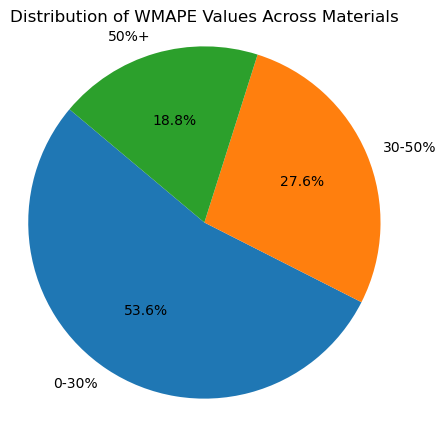

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define WMAPE ranges according to the new categorization
wmape_ranges = {'0-30%': (0, 0.3), '30-50%': (0.3, 0.5), '50%+': (0.5, 1)}

# Initialize a dictionary for counting materials in each WMAPE range
wmape_distribution = {key: 0 for key in wmape_ranges}

# Categorize each material's WMAPE into defined ranges
for wmape in best_model_df['Lowest WMAPE']:
    for range_key, (lower_bound, upper_bound) in wmape_ranges.items():
        if range_key != '50%+':
            if lower_bound <= wmape < upper_bound:
                wmape_distribution[range_key] += 1
                break
        else:  # For the last range, include both bounds
            if lower_bound <= wmape:
                wmape_distribution[range_key] += 1
                break

# Convert the distribution dictionary to a DataFrame
buckets_df = pd.DataFrame(list(wmape_distribution.items()), columns=['WMAPE Range', 'Material Count'])

# Display the DataFrame
print(buckets_df, "\n\n")

# Plot a pie chart for the WMAPE distribution
plt.figure(figsize=(5, 5))
plt.pie(buckets_df['Material Count'], labels=buckets_df['WMAPE Range'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of WMAPE Values Across Materials')
plt.show()

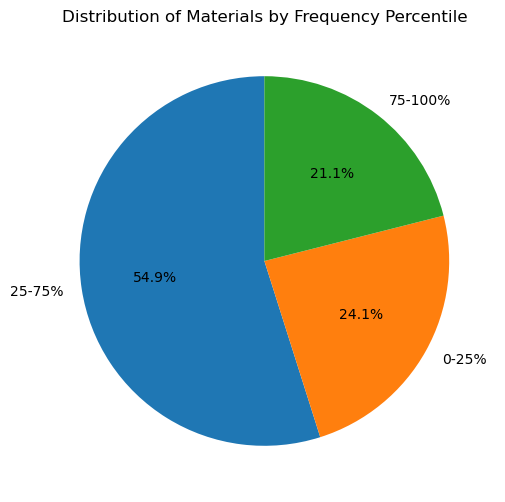

In [ ]:
import matplotlib.pyplot as plt

# Assuming best_model_df is already defined and includes a 'Frequency Percentile' column

# Count of 'Material' for each 'Frequency Percentile'
frequency_percentile_counts = best_model_df['Frequency Percentile'].value_counts()

# Generate pie chart
plt.figure(figsize=(10, 6))
plt.pie(frequency_percentile_counts, labels=frequency_percentile_counts.index, autopct='%1.1f%%', startangle=90)

# Optional: If you prefer a donut chart, you can uncomment the following two lines
# center_circle = plt.Circle((0, 0), 0.70, color='black', fc='white', linewidth=1.25)
# plt.gca().add_artist(center_circle)

plt.title('Distribution of Materials by Frequency Percentile')
plt.show()


for best model frequency distribution

##Formation and Saving of Predicted validation table

In [ ]:
# Initialize DataFrames for storing validation mean and max predictions
validation_mean = pd.DataFrame()
#validation_max = pd.DataFrame()
std_dev = pd.DataFrame()

# Initialize Req.Date column in both DataFrames
validation_mean['Req.Date'] = pivot_df['Req.Date'].iloc[-90:].reset_index(drop=True)
std_dev['Req.Date'] = pivot_df['Req.Date'].iloc[-90:].reset_index(drop=True)

# Loop through each material to select the corresponding predictions
for material in best_model_df['Material']:
    # Retrieve the best model for the current material
    best_model = best_model_df.loc[best_model_df['Material'] == material, 'Best Model'].iloc[0]

    # Dynamically select the appropriate DataFrame for mean predictions
    if best_model == 'CNN':
        mean_predictions = mean_df_cnn[material].values
        std_dev_df = std_dev_df_cnn[material].values
    elif best_model == 'WaveNet':
        mean_predictions = mean_df_wavenet[material].values
        std_dev_df = std_dev_df_cnn_comb[material].values
    elif best_model == 'Combined_CNN':
        mean_predictions = mean_df_cnn[material].values
        std_dev_df = std_dev_df_wavenet[material].values
    else:  # Combined_WaveNet
        mean_predictions = mean_df_wave_comb[material].values
        std_dev_df = std_dev_df_wave_comb[material].values

    # Add the selected predictions to the validation DataFrames
    validation_mean[material] = mean_predictions
    std_dev[material] = std_dev_df


#Saving monthly validation_mean
import pandas as pd
# Assuming validation_mean DataFrame is already defined
# Create a copy of validation_mean to preserve the original DataFrame
validation_mean_copy = validation_mean.copy()
# Ensure Req.Date is in datetime format
validation_mean_copy['Req.Date'] = pd.to_datetime(validation_mean_copy['Req.Date'])
# Extract Year and Month for aggregation
validation_mean_copy['Year'] = validation_mean_copy['Req.Date'].dt.year
validation_mean_copy['Month'] = validation_mean_copy['Req.Date'].dt.month
# Group by Year and Month, summing up all values (assuming other columns are numeric values to be summed)
grouped = validation_mean_copy.groupby(['Year', 'Month']).sum().reset_index()
# Replace Year and Month with the first day of each month for Req.Date
grouped['Req.Date'] = pd.to_datetime(grouped[['Year', 'Month']].assign(DAY=1))
# Drop Year and Month columns as they are no longer needed
validation_mean_monthly = grouped.drop(['Year', 'Month'], axis=1)
# Arrange columns to have Req.Date as the first column
validation_mean_monthly = validation_mean_monthly[['Req.Date'] + [col for col in validation_mean_monthly.columns if col != 'Req.Date']]


#Saving monthly std_dev
import pandas as pd
# Assuming std_dev DataFrame is already defined
# Create a copy of std_dev to preserve the original DataFrame
std_dev_copy = std_dev.copy()
# Ensure Req.Date is in datetime format
std_dev_copy['Req.Date'] = pd.to_datetime(std_dev_copy['Req.Date'])
# Extract Year and Month for aggregation
std_dev_copy['Year'] = std_dev_copy['Req.Date'].dt.year
std_dev_copy['Month'] = std_dev_copy['Req.Date'].dt.month
# Group by Year and Month, summing up all values (assuming other columns are numeric values to be summed)
grouped = std_dev_copy.groupby(['Year', 'Month']).sum().reset_index()
# Replace Year and Month with the first day of each month for Req.Date
grouped['Req.Date'] = pd.to_datetime(grouped[['Year', 'Month']].assign(DAY=1))
# Drop Year and Month columns as they are no longer needed
std_dev_monthly = grouped.drop(['Year', 'Month'], axis=1)
# Arrange columns to have Req.Date as the first column
std_dev_monthly = std_dev_monthly[['Req.Date'] + [col for col in std_dev_monthly.columns if col != 'Req.Date']]
# std_dev_monthly now contains the aggregated monthly values, structured with Req.Date as the first column, without altering the original std_dev
#std_dev_monthly

/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/341243860.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  validation_mean[material] = mean_predictions
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/341243860.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  std_dev[material] = std_dev_df
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/341243860.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

Req.Date   K1053-8   K1053-9       K1170   K1170-5   K1170-6  K1288-17  \
0 2023-09-01  0.840718  1.463511   38.669124  1.530309  0.024725  1.838607   
1 2023-10-01  3.156482  6.323117  162.954342  6.692500  0.109213  7.685396   
2 2023-11-01  3.410696  6.805394  174.915056  7.561926  0.113247  8.101606   
3 2023-12-01  2.531471  5.114438  126.402629  6.507992  0.079619  5.347037   

       K1297  K1365-23   K1365-29  ...       K814   K852-25    K852-50  \
0   8.677776  1.371287   2.570820  ...   3.024160  0.890642   2.737928   
1  37.362099  6.298648  10.838265  ...  12.308458  3.832545  10.951247   
2  41.381204  6.240484  11.906112  ...  13.540847  4.061594  12.015997   
3  30.483610  4.644654   8.090225  ...   9.933073  3.052569   8.292488   

     K852-70    K852-95      K875      K909-6   K940-25   K940-75       K96  
0   5.196625   4.898702  1.597761   49.574299  2.269900  1.481872  0.705848  
1  23.879751  21.376567  6.904896  191.971795  9.135072  6.128619  2.709231  
2  26.025620  21.291479  6.979318  198.535445  9.947301  6.700655  3.001999  
3  18.646409  16.926667  5.423202  130.071486  6.758218  4.719958  2.314117  

[4 rows x 262 columns]

Check

In [ ]:
#validation_mean

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.201384  0.082868  13.984217  0.016792  0.000000  0.556412   
1  2023-09-24  0.203927  0.082046  12.224569  0.018740  0.000000  0.618451   
2  2023-09-25  0.619196  0.126622  23.217485  0.000000  0.000000  0.910222   
3  2023-09-26  0.510573  0.446283  36.518814  0.018082  0.000000  0.942762   
4  2023-09-27  0.507320  0.339697  32.605134  0.000000  0.000069  0.594344   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.202258  0.068557  14.802280  0.051371  0.000000  0.642403   
86 2023-12-18  0.641474  0.465420  34.253632  0.077388  0.000000  0.904077   
87 2023-12-19  0.488591  0.462406  32.998910  0.405740  0.004827  0.950507   
88 2023-12-20  0.393221  0.320728  33.171845  0.271334  0.002264  0.623541   
89 2023-12-21  0.630694  0.232989  40.098083  0.176415  0.001264  0.419981   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   3.419216  0.084503  0.000000  ...  0.484095  0.264791  0.195806  2.268975   
1   3.463821  0.011852  0.072158  ...  0.491143  0.257286  0.269075  2.285859   
2   8.111871  0.411098  0.045966  ...  1.751596  0.320724  0.443616  3.468181   
3   8.226248  0.829367  0.010253  ...  0.999498  0.458989  0.520371  3.365647   
4   7.761938  0.485162  0.232692  ...  1.190623  0.407222  0.445189  3.264712   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  3.430909  0.093108  0.191510  ...  0.431205  0.209186  0.401222  2.316389   
86  8.375160  0.617238  0.331461  ...  1.338216  0.434247  0.552701  3.830317   
87  8.882867  0.694488  0.000000  ...  1.096383  0.742485  0.350948  3.535268   
88  8.371642  0.352407  0.000000  ...  1.140417  0.465120  0.242646  3.866545   
89  9.115362  0.389270  0.523245  ...  1.385000  0.450394  0.571354  4.804136   

     K852-95      K875     K909-6   K940-25   K940-75       K96  
0   1.483944  0.317791  12.791068  0.467185  0.118768  0.049978  
1   1.122916  0.216690  13.880908  0.531197  0.136167  0.033323  
2   1.742157  0.488046  27.074772  1.919980  0.075025  0.193962  
3   2.717744  0.690622  32.817643  2.351607  0.072561  0.395865  
4   2.328654  0.452636  25.050699  1.946955  0.184373  0.286155  
..       ...       ...        ...       ...       ...       ...  
85  1.143144  0.272016  14.381419  0.473715  0.196792  0.047646  
86  2.138009  0.343794  25.248863  2.667112  0.211192  0.325269  
87  3.156106  0.703582  32.927571  2.225776  0.000000  0.489283  
88  2.483876  0.817083  29.060123  2.009801  0.012132  0.443648  
89  2.574224  0.906433  31.941021  2.836289  0.235980  0.390943  

[90 rows x 262 columns]

In [ ]:
#std_dev

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  K1288-17  \
0  2023-09-23  0.117473  0.030652   0.289039  0.098942  0.000406  0.022541   
1  2023-09-24  0.014026  0.024815   0.612872  0.025751  0.000603  0.032219   
2  2023-09-25  0.155779  0.290028   6.935339  0.223655  0.004169  0.373954   
3  2023-09-26  0.178611  0.323088   9.424086  0.372025  0.005996  0.361931   
4  2023-09-27  0.127236  0.296147   6.747663  0.258280  0.005499  0.357233   
..        ...       ...       ...        ...       ...       ...       ...   
85 2023-12-17  0.044527  0.033760   1.487566  0.138870  0.001563  0.042639   
86 2023-12-18  0.138312  0.349247   7.801069  0.297474  0.005685  0.362505   
87 2023-12-19  0.233703  0.327372  10.661176  0.532543  0.005604  0.409014   
88 2023-12-20  0.194264  0.325535   7.500639  0.475056  0.004748  0.289486   
89 2023-12-21  0.187342  0.364856   9.091488  0.354843  0.006766  0.390450   

       K1297  K1365-23  K1365-29  ...      K814   K852-25   K852-50   K852-70  \
0   0.174768  0.081989  0.036079  ...  0.359541  0.015652  0.035275  0.006689   
1   0.164020  0.029489  0.072791  ...  0.061533  0.010449  0.064340  0.112821   
2   1.887441  0.209436  0.473463  ...  0.563779  0.120264  0.515801  1.059545   
3   1.793299  0.382899  0.505971  ...  0.826099  0.192604  0.577632  1.414418   
4   1.796673  0.269909  0.431157  ...  0.491686  0.209886  0.448625  0.961816   
..       ...       ...       ...  ...       ...       ...       ...       ...   
85  0.141786  0.070660  0.080181  ...  0.167592  0.047089  0.066251  0.120375   
86  2.090412  0.338023  0.559738  ...  0.545114  0.218909  0.534452  0.926816   
87  1.921701  0.389648  0.532779  ...  0.807449  0.260337  0.563449  1.105151   
88  2.336452  0.300645  0.495716  ...  0.638069  0.183940  0.516336  1.032455   
89  2.264736  0.291723  0.647186  ...  0.661822  0.246366  0.584572  1.534330   

     K852-95      K875     K909-6   K940-25   K940-75       K96  
0   0.327660  0.099459   0.920182  0.238770  0.021918  0.083107  
1   0.087479  0.028241   1.697052  0.073045  0.025795  0.010326  
2   0.651650  0.244285   8.881808  0.429583  0.278050  0.138486  
3   1.246597  0.441510  10.062688  0.559074  0.298665  0.172176  
4   1.201567  0.344505   7.715848  0.397962  0.304528  0.098784  
..       ...       ...        ...       ...       ...       ...  
85  0.163455  0.061657   1.090055  0.105974  0.037784  0.047106  
86  1.075152  0.257056   8.336187  0.340354  0.343660  0.131314  
87  1.410483  0.459099   9.750534  0.521439  0.358473  0.201542  
88  1.249268  0.387464   7.168657  0.546342  0.245958  0.155688  
89  1.003799  0.352782   8.639327  0.538524  0.348597  0.167975  

[90 rows x 262 columns]

In [ ]:
#validation_mean_monthly

Req.Date    K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-09-01   3.148117  1.612518  178.145064  0.732904  0.001959   5.821925   
1 2023-10-01  13.315737  5.124483  729.812291  2.927151  0.021726  20.289809   
2 2023-11-01  13.975435  5.830749  767.206720  5.304172  0.011134  19.165669   
3 2023-12-01   9.602401  4.707518  561.318206  3.988063  0.015708  13.398095   

        K1297   K1365-23  K1365-29  ...       K814    K852-25    K852-50  \
0   47.698858   2.368065  0.954937  ...   6.958710   2.755483   3.023169   
1  189.775473   8.410595  3.543743  ...  28.978773  11.812331  11.933319   
2  197.625046  11.429198  4.593429  ...  25.375894  10.874216  13.836202   
3  146.374075   8.150041  3.417880  ...  16.249169   8.291081   9.351644   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0  23.038874  14.944391   2.896370  174.300248  10.820063  0.937177  1.527638  
1  92.915652  49.804412  13.705182  645.605550  44.908429  4.458781  6.535392  
2  99.288638  56.327670  12.820251  650.629072  49.234212  5.433877  7.611515  
3  73.157741  43.296940  11.192942  472.500324  36.909738  3.261240  5.637855  

[4 rows x 262 columns]

In [ ]:
#std_dev_monthly

Req.Date   K1053-8   K1053-9       K1170   K1170-5   K1170-6  K1288-17  \
0 2023-09-01  0.840718  1.463511   38.669124  1.530309  0.024725  1.838607   
1 2023-10-01  3.156482  6.323117  162.954342  6.692500  0.109213  7.685396   
2 2023-11-01  3.410696  6.805394  174.915056  7.561926  0.113247  8.101606   
3 2023-12-01  2.531471  5.114438  126.402629  6.507992  0.079619  5.347037   

       K1297  K1365-23   K1365-29  ...       K814   K852-25    K852-50  \
0   8.677776  1.371287   2.570820  ...   3.024160  0.890642   2.737928   
1  37.362099  6.298648  10.838265  ...  12.308458  3.832545  10.951247   
2  41.381204  6.240484  11.906112  ...  13.540847  4.061594  12.015997   
3  30.483610  4.644654   8.090225  ...   9.933073  3.052569   8.292488   

     K852-70    K852-95      K875      K909-6   K940-25   K940-75       K96  
0   5.196625   4.898702  1.597761   49.574299  2.269900  1.481872  0.705848  
1  23.879751  21.376567  6.904896  191.971795  9.135072  6.128619  2.709231  
2  26.025620  21.291479  6.979318  198.535445  9.947301  6.700655  3.001999  
3  18.646409  16.926667  5.423202  130.071486  6.758218  4.719958  2.314117  

[4 rows x 262 columns]

# Rules for reducing gap between max and standard

1. 95% CI

In [ ]:
import pandas as pd

# Create a copy of validation_mean_monthly to preserve its original state
max_df_90 = validation_mean_monthly.copy()

# Iterate over the columns starting from the 2nd column (index 1) to update max_df_90 according to the formula
for column in validation_mean.columns[1:]:  # Skip the first column
    max_df_90[column] = validation_mean_monthly[column] + 1.65 * std_dev_monthly[column]

#max_df_90

Req.Date    K1053-8    K1053-9        K1170    K1170-5   K1170-6  \
0 2023-09-01   4.535303   4.027312   241.949118   3.257913  0.042756   
1 2023-10-01  18.523933  15.557627   998.686956  13.969775  0.201927   
2 2023-11-01  19.603083  17.059649  1055.816561  17.781350  0.197991   
3 2023-12-01  13.779329  13.146341   769.882544  14.726249  0.147079   

    K1288-17       K1297   K1365-23   K1365-29  ...       K814    K852-25  \
0   8.855627   62.017189   4.630689   5.196790  ...  11.948574   4.225042   
1  32.970712  251.422937  18.803364  21.426880  ...  49.287729  18.136030   
2  32.533318  265.904034  21.725998  24.238513  ...  47.718291  17.575847   
3  22.220707  196.672031  15.813721  16.766751  ...  32.638739  13.327820   

     K852-50     K852-70    K852-95       K875      K909-6    K940-25  \
0   7.540750   31.613305  23.027249   5.532675  256.097842  14.565398   
1  30.002877  132.317242  85.075746  25.098261  962.359011  59.981298   
2  33.662597  142.230910  91.458610  24.336126  978.212557  65.647258   
3  23.034250  103.924316  71.225941  20.141226  687.118276  48.060798   

     K940-75        K96  
0   3.382265   2.692289  
1  14.571002  11.005623  
2  16.489958  12.564813  
3  11.049170   9.456148  

[4 rows x 262 columns]

Distribution of Max factor initial

In [ ]:
import pandas as pd

# Assuming max_df_90 and validation_mean_monthly are your DataFrames
# Calculate max_factor
max_factor_df_1 = max_df_90.iloc[:, 1:].div(validation_mean_monthly.iloc[:, 1:])

# Take the average of each column
avg_max_factor_1 = max_factor_df_1.mean()

# Store averages against the column name in a separate DataFrame
avg_max_factor_df_1 = pd.DataFrame(avg_max_factor_1, columns=['Average Max Factor 1'])
#avg_max_factor_df_1

Average Max Factor 1
K1053-8              1.417360
K1053-9              2.812976
K1170                1.368580
K1170-5              4.065653
K1170-6             14.566510
...                       ...
K875                 1.859805
K909-6               1.479407
K940-25              1.329317
K940-75              3.324903
K96                  1.693603

[261 rows x 1 columns]

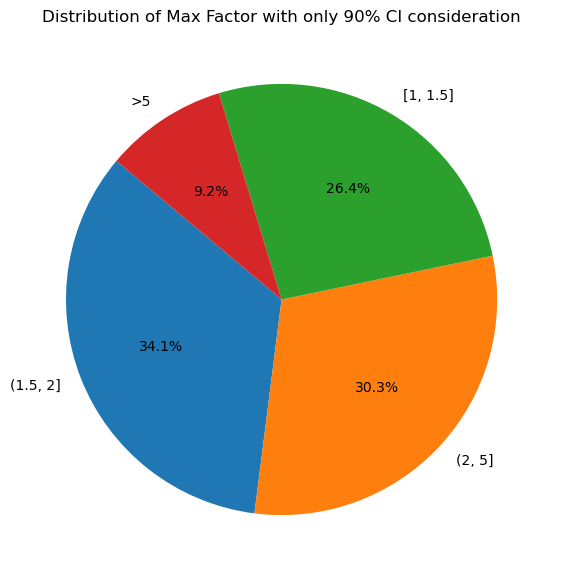

In [ ]:
import matplotlib.pyplot as plt

# Categorize the average max factors
categories = ['[1, 1.5]', '(1.5, 2]', '(2, 5]', '>5']
categorized_avg_max_factor_1 = pd.cut(avg_max_factor_df_1['Average Max Factor 1'],
                                    bins=[1, 1.5, 2, 5, float('inf')],
                                    right=True,
                                    labels=categories)

# Count the occurrences in each category
category_counts = categorized_avg_max_factor_1.value_counts()

# Plot Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Max Factor with only 90% CI consideration')
plt.show()

2. MIF

In [ ]:
#Enter the existing model WMAPE for a given segment
WMAPE_ex_lvar_hvol = 0.415
WMAPE_new_lvar_hvol= overall_avg_wmape
MIF = round((WMAPE_ex_lvar_hvol-WMAPE_new_lvar_hvol)/WMAPE_ex_lvar_hvol,2)
print("MIF = ", MIF)

# Create a copy of validation_mean to preserve its original state
new_max_df = validation_mean_monthly.copy()

# Iterate over the columns starting from the 2nd column (index 1) to update max_df_90 according to the formula
for column in new_max_df.columns[1:]:  # Skip the first column
    new_max_df[column] = validation_mean_monthly[column] + 1.65 * std_dev_monthly[column] * (1-MIF)

#new_max_df


MIF =  0.42


Req.Date    K1053-8    K1053-9       K1170    K1170-5   K1170-6  \
0 2023-09-01   3.952685   3.013098  215.151415   2.197409  0.025621   
1 2023-10-01  16.336491  11.175706  885.759596   9.331873  0.126243   
2 2023-11-01  17.239471  12.343511  934.600428  12.540935  0.119511   
3 2023-12-01  12.025019   9.602035  682.285522  10.216211  0.091903   

    K1288-17       K1297   K1365-23   K1365-29  ...       K814    K852-25  \
0   7.581472   56.003490   3.680387   3.415212  ...   9.852831   3.607827   
1  27.644732  225.531002  14.438401  13.915962  ...  40.757968  15.480077   
2  26.918905  237.226859  17.401342  15.987577  ...  38.334484  14.761162   
3  18.515210  175.546890  12.594975  11.160226  ...  25.755119  11.212390   

     K852-50     K852-70    K852-95       K875      K909-6    K940-25  \
0   5.643366   28.012044  19.632449   4.425427  221.742853  12.992357   
1  22.413662  115.768574  70.261786  20.313168  829.322557  53.650693   
2  25.335511  124.195156  76.703615  19.499459  840.627494  58.753779   
3  17.287555   91.002354  59.495761  16.382947  596.978736  43.377353   

     K940-75        K96  
0   2.355328   2.203136  
1  10.323869   9.128126  
2  11.846404  10.484428  
3   7.778239   7.852465  

[4 rows x 262 columns]

Distribution of Max factor after considering MIF factor

In [ ]:
import pandas as pd

# Assuming new_max_df and validation_mean_monthly are your DataFrames
# Calculate max_factor
max_factor_df = new_max_df.iloc[:, 1:].div(validation_mean_monthly.iloc[:, 1:])

# Take the average of each column
avg_max_factor = max_factor_df.mean()

# Store averages against the column name in a separate DataFrame
avg_max_factor_df = pd.DataFrame(avg_max_factor, columns=['Average Max Factor 2'])
#avg_max_factor_df
#avg_max_factor_df.to_csv("avg_max_factor_df.csv")

Average Max Factor 2
K1053-8              1.242069
K1053-9              2.051526
K1170                1.213776
K1170-5              2.778078
K1170-6              8.868576
...                       ...
K875                 1.498687
K909-6               1.278056
K940-25              1.191004
K940-75              2.348444
K96                  1.402290

[261 rows x 1 columns]

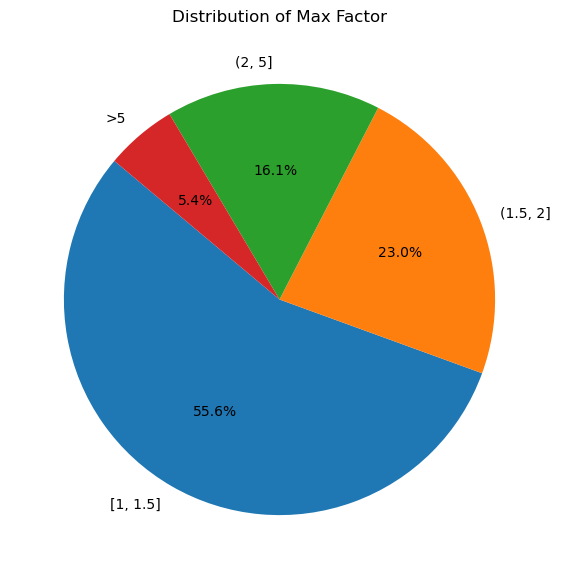

In [ ]:
import matplotlib.pyplot as plt

# Categorize the average max factors
categories = ['[1, 1.5]', '(1.5, 2]', '(2, 5]', '>5']
categorized_avg_max_factor = pd.cut(avg_max_factor_df['Average Max Factor 2'],
                                    bins=[1, 1.5, 2, 5, float('inf')],
                                    right=True,
                                    labels=categories)

# Count the occurrences in each category
category_counts = categorized_avg_max_factor.value_counts()

# Plot Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Max Factor')
plt.show()


3. Setting upper limit for max predictions

In [ ]:
import pandas as pd

# Assuming new_max_df and validation_df_monthly are your initial DataFrames and have been defined

# Multiply validation_df_monthly by 2 from the 2nd column onwards
adjusted_validation_mean_monthly = validation_mean_monthly.copy()  # Create a copy to preserve the original DataFrame
adjusted_validation_mean_monthly.iloc[:, 1:] *= 2 # Adjust only from the 2nd column to the end

# Create a new DataFrame to store the minimum values between new_max_df and adjusted_validation_df
new_max_df_2 = new_max_df.copy()  # Start with a copy of new_max_df

# Compare and take the minimum value from the 2nd column to the last
for column in new_max_df.columns[1:]:  # Skip the first column
    new_max_df_2[column] = new_max_df[column].combine(adjusted_validation_mean_monthly[column], min)

# new_max_df_2 now contains the minimum values as requested
#new_max_df_2

Req.Date    K1053-8    K1053-9       K1170    K1170-5   K1170-6  \
0 2023-09-01   3.952685   3.013098  215.151415   1.465808  0.003918   
1 2023-10-01  16.336491  10.248966  885.759596   5.854301  0.043452   
2 2023-11-01  17.239471  11.661498  934.600428  10.608343  0.022267   
3 2023-12-01  12.025019   9.415036  682.285522   7.976125  0.031416   

    K1288-17       K1297   K1365-23  K1365-29  ...       K814    K852-25  \
0   7.581472   56.003490   3.680387  1.909874  ...   9.852831   3.607827   
1  27.644732  225.531002  14.438401  7.087486  ...  40.757968  15.480077   
2  26.918905  237.226859  17.401342  9.186857  ...  38.334484  14.761162   
3  18.515210  175.546890  12.594975  6.835761  ...  25.755119  11.212390   

     K852-50     K852-70    K852-95       K875      K909-6    K940-25  \
0   5.643366   28.012044  19.632449   4.425427  221.742853  12.992357   
1  22.413662  115.768574  70.261786  20.313168  829.322557  53.650693   
2  25.335511  124.195156  76.703615  19.499459  840.627494  58.753779   
3  17.287555   91.002354  59.495761  16.382947  596.978736  43.377353   

     K940-75        K96  
0   1.874354   2.203136  
1   8.917561   9.128126  
2  10.867754  10.484428  
3   6.522479   7.852465  

[4 rows x 262 columns]

### Calculating percentage difference between standard and max forecast

In [ ]:
def P_diff(mean, max, epsilon=1e-8):
    per_diff = (np.sum(max))/(np.sum(mean)+epsilon)
    avg_per_diff = np.mean(per_diff)
    avg_per_diff_percentage = f"{avg_per_diff * 100:.2f}%"
    return avg_per_diff_percentage

validation_mean_monthly_mat = validation_mean_monthly.iloc[:,1:]
new_max_df_2_mat = new_max_df_2.iloc[:,1:]

Pdiff =P_diff(validation_mean_monthly_mat, new_max_df_2_mat, epsilon=1e-8)
#Pdiff

'154.21%'

## Plot Actual vs Predicted std. forecast and max forecast

Specific material - 1

WMAPE for material K1170 (Monthly Mean Predictions): 6.03%


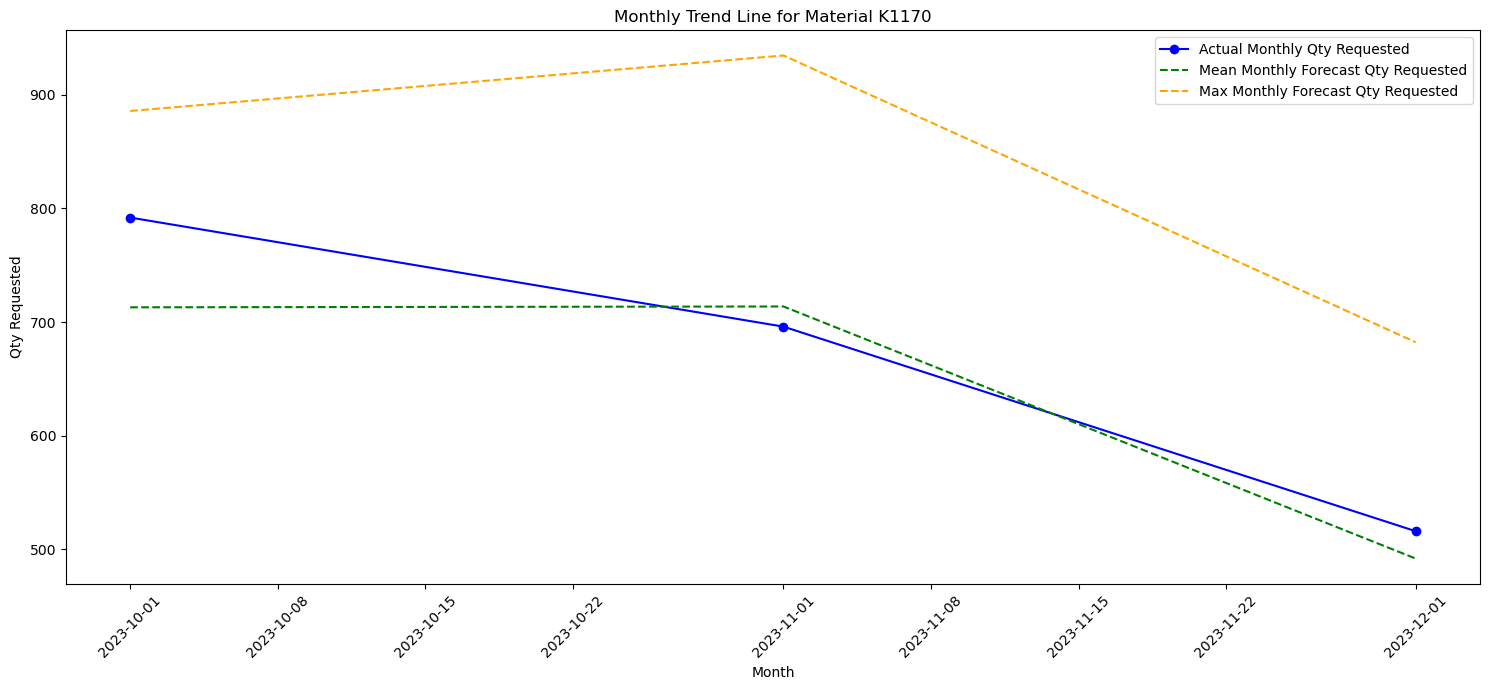

/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4156748656.py:70: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pivot_df_quarterly_sum = pivot_df_monthly_sorted.groupby(pivot_df_monthly_sorted['Req.Date'].dt.to_period('Q')).sum()
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4156748656.py:71: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quarterly_sum = mean_df_monthly.groupby(mean_df_monthly['Req.Date'].dt.to_period('Q')).sum()[specific_material][-2:]  # Last 1 quarters
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4156748656.py:73: FutureWarning: The 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def calculate_wmape(actual, predicted, epsilon=1e-8):
    # Calculate the error as the absolute difference between the actual and predicted values
    error = np.abs(actual - predicted)
    # If the error is greater than the actual, retain the actual value as the error
    error = np.where(error > actual, actual, error)
    # Calculate the sum of all errors
    sum_error = np.sum(error)
    # Calculate the sum of all actual values
    sum_actual = np.sum(actual)
    # Return the ratio of the sum of all errors to the sum of all actual values, include epsilon to prevent division by zero
    return sum_error / (sum_actual + epsilon)  # Prevent division by zero

# Assuming 'best_model_df' is already created and contains the best model information for each material
specific_material = 'K1170'  # Change this to the material you want to analyze

# Find the best model for the specific material
best_model = best_model_df.loc[best_model_df['Material'] == specific_material, 'Best Model'].iloc[0]

# Dynamically assign monthly mean and max DataFrames based on the best model
if best_model == 'CNN':
    mean_df_monthly = mean_df_cnn_monthly
elif best_model == 'WaveNet':
    mean_df_monthly = mean_df_wavenet_monthly
elif best_model == 'Combined_CNN':
    mean_df_monthly = mean_df_cnn_comb_monthly
else:  # Combined_WaveNet
    mean_df_monthly = mean_df_wave_comb_monthly

# Considering last 3 month entries
pivot_df_monthly_sorted = pivot_df_monthly.sort_values('Req.Date').tail(3)
actual_monthly_values = pivot_df_monthly_sorted[specific_material].values
predicted_mean_monthly_values = mean_df_monthly[specific_material].values[-3:]  # Correctly fetch the last 3 months
predicted_final_max_monthly_values = new_max_df_2[specific_material].values[-3:]  # Correctly fetch the last 3 months, assuming final_max_df_month is defined and has last 6 months data

# Calculate WMAPE for the specific material on monthly basis
wmape_mean_monthly = calculate_wmape(actual_monthly_values, predicted_mean_monthly_values)
print(f"WMAPE for material {specific_material} (Monthly Mean Predictions): {wmape_mean_monthly*100:.2f}%")

# Plotting Monthly
plt.figure(figsize=(15, 7))
plt.plot(pivot_df_monthly_sorted['Req.Date'], actual_monthly_values, label='Actual Monthly Qty Requested', marker='o', color='blue')
plt.plot(mean_df_monthly['Req.Date'].tail(3), predicted_mean_monthly_values, label='Mean Monthly Forecast Qty Requested', linestyle='--', color='green')
plt.plot(new_max_df_2['Req.Date'].tail(3), predicted_final_max_monthly_values, label='Max Monthly Forecast Qty Requested', linestyle='--', color='orange')  # Ensure final_max_df_month is correctly defined
plt.title(f'Monthly Trend Line for Material {specific_material}')
plt.xlabel('Month')
plt.ylabel('Qty Requested')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Convert 'Req.Date' to datetime format in all DataFrames if not already done
pivot_df_monthly['Req.Date'] = pd.to_datetime(pivot_df_monthly['Req.Date'])
mean_df_monthly['Req.Date'] = pd.to_datetime(mean_df_monthly['Req.Date'])
new_max_df_2['Req.Date'] = pd.to_datetime(new_max_df_2['Req.Date'])  # Assuming new_max_df_2 has 'Req.Date'

# Group by quarter and sum the values for each material
pivot_df_quarterly_sum = pivot_df_monthly_sorted.groupby(pivot_df_monthly_sorted['Req.Date'].dt.to_period('Q')).sum()
mean_quarterly_sum = mean_df_monthly.groupby(mean_df_monthly['Req.Date'].dt.to_period('Q')).sum()[specific_material][-2:]  # Last 1 quarters
final_max_quarterly_sum = new_max_df_2.groupby(new_max_df_2['Req.Date'].dt.to_period('Q')).sum()[specific_material][-2:]  # Last 1 quarters



# Future Forecasts: All the codes below take longer to run

Future Predictions for CNN

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model  # or your model's import


# Prepare the scaler and fit it on your dataset excluding 'Req.Date'
columns_to_scale = [col for col in pivot_df.columns if col not in ['Req.Date', 'Week', 'Month']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(pivot_df[columns_to_scale])

# Generate future dates
last_known_date = pd.to_datetime(pivot_df['Req.Date'].iloc[-1])
future_dates = [last_known_date + timedelta(days=x) for x in range(1, 91)]


# Function to generate cyclic features for each future date
def generate_cyclic_features(date):
    week_sin = np.sin(2 * np.pi * date.weekday() / 7)
    week_cos = np.cos(2 * np.pi * date.weekday() / 7)
    month_sin = np.sin(2 * np.pi * (date.month - 1) / 12)
    month_cos = np.cos(2 * np.pi * (date.month - 1) / 12)
    return np.array([week_sin, week_cos, month_sin, month_cos])

# Prepare the initial sequence for prediction
all_materials = pivot_df.columns[1:-6]
all_materials_scaled = scaler.transform(pivot_df[columns_to_scale])
seq_length = 365  # Adjust based on your model's expected input sequence length
last_sequences = all_materials_scaled[-seq_length:]


# Initialize future predictions DataFrame
cnn_future_predictions_mean = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])
cnn_future_predictions_std_dev = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])

# Function to generate predictions using MC dropout
def generate_mc_dropout_predictions(model, input_sequence, num_samples=100):
    predictions = np.array([model.predict(input_sequence) for _ in range(num_samples)])
    mean_predictions = np.mean(predictions, axis=0)[0]
    std_dev_predictions = np.std(predictions, axis=0)[0]  # Compute standard deviation
    return mean_predictions, std_dev_predictions

# Predict future values using MC dropout
for date in future_dates:
    cyclic_features = generate_cyclic_features(date).reshape(1, 4)
    if last_sequences.ndim == 2:
        last_sequences = last_sequences.reshape(1, last_sequences.shape[0], last_sequences.shape[1])
    input_sequence = np.concatenate([last_sequences[:, :, :-4], np.tile(cyclic_features, (1, last_sequences.shape[1], 1))], axis=-1)

    # Use MC dropout to generate predictions
    mean_pred, std_dev_pred = generate_mc_dropout_predictions(model_cnn, input_sequence, num_samples=num_samples)


    # Reshape and process predictions for inverse scaling
    mean_pred_processed = np.hstack((mean_pred.reshape(1, -1), cyclic_features))
    std_dev_pred_processed = np.hstack((std_dev_pred.reshape(1, -1), cyclic_features))  # New line for std_dev
    mean_pred_rescaled = scaler.inverse_transform(mean_pred_processed)[0, :-4]
    std_dev_pred_rescaled = scaler.inverse_transform(std_dev_pred_processed)[0, :-4]  # Inverse scaling std_dev

    # Clip negative predictions to 0
    mean_pred_rescaled_clipped = np.clip(mean_pred_rescaled, 0, None)

    # Update future predictions DataFrames
    cnn_future_predictions_mean.loc[date] = mean_pred_rescaled_clipped[:len(all_materials)]
    cnn_future_predictions_std_dev.loc[date] = std_dev_pred_rescaled[:len(all_materials)]  # Updating std_dev DataFrame

    # Prepare for next prediction
    last_sequences = np.roll(last_sequences, -1, axis=1)
    last_sequences[0, -1, :-4] = mean_pred  # Using mean predictions to update the sequence

# Add 'Req.Date' to the future predictions DataFrame
cnn_future_predictions_mean.insert(0, 'Req.Date', future_dates)
cnn_future_predictions_std_dev.insert(0, 'Req.Date', future_dates)


#Monthly-wise aggregations

# Assuming dataframes 'cnn_future_predictions_mean', 'cnn_future_predictions_max', and 'cnn_future_predictions_std_dev' are already defined
dataframes = {
    'cnn_future_predictions_mean': cnn_future_predictions_mean,
    #'cnn_future_predictions_max': cnn_future_predictions_max,
    'cnn_future_predictions_std_dev': cnn_future_predictions_std_dev
}

# Initialize a dictionary to hold the aggregated monthly DataFrames for later access
monthly_aggregated_dataframes_cnn = {}

for name, df in dataframes.items():
    # Create a copy to preserve the original DataFrame
    df_copy = df.copy()

    # Ensure 'Req.Date' is in datetime format if not already
    df_copy['Req.Date'] = pd.to_datetime(df_copy['Req.Date'])

    # Set 'Req.Date' as the DataFrame index (temporarily for resampling)
    df_copy.set_index('Req.Date', inplace=True)

    # Aggregate by Year-Month, summing up values for each material
    df_monthly = df_copy.resample('MS').sum()

    # Reset the index to bring 'Req.Date' back as a column
    df_monthly.reset_index(inplace=True)

    # Store the aggregated monthly DataFrame in the dictionary for immediate use and saving
    monthly_aggregated_dataframes_cnn[name + '_monthly'] = df_monthly


# At this point, monthly_aggregated_dataframes_cnn dictionary contains all the monthly aggregated DataFrames
# For example, to access the mean monthly DataFrame directly in the code, you can use:
cnn_future_predictions_mean_monthly = monthly_aggregated_dataframes_cnn['cnn_future_predictions_mean_monthly']
cnn_future_predictions_std_dev_monthly = monthly_aggregated_dataframes_cnn['cnn_future_predictions_std_dev_monthly']


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
cnn_future_predictions_mean_monthly saved to cnn_future_predictions_mean_monthly.csv
cnn_future_predictions_std_dev_monthly saved to cnn_future_predictions_std_dev_monthly.csv


/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/3215399202.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/3215399202.py:119: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)


Future Predictions for Combined CNN

In [ ]:
# Initialize future predictions DataFrame for Combined_CNN
combined_cnn_future_predictions_mean = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])
combined_cnn_future_predictions_std_dev = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])

# Function to generate predictions using MC dropout for both classification and forecasting
def generate_combined_mc_dropout_predictions(classification_model, forecasting_model, input_sequence, num_samples=100):
    order_presence_samples = np.array([classification_model.predict(input_sequence) for _ in range(num_samples)])
    forecast_samples = np.array([forecasting_model.predict(input_sequence) for _ in range(num_samples)])

    # Calculate mean order presence probability across all samples
    mean_order_presence = np.mean(order_presence_samples, axis=0)[0] > 0.5

    # Calculate mean and max across forecast samples
    mean_forecasts = np.mean(forecast_samples, axis=0)[0]
    std_dev_forecasts = np.std(forecast_samples, axis=0)[0]  # Calculate std dev


    # Combine classification and forecasting
    combined_mean_predictions = np.where(mean_order_presence, mean_forecasts, 0)
    combined_std_dev_predictions = np.where(mean_order_presence, std_dev_forecasts, 0)  # Apply std dev

    return combined_mean_predictions, combined_std_dev_predictions

# Predict future values using MC dropout for Combined_CNN
for date in future_dates:
    cyclic_features = generate_cyclic_features(date).reshape(1, 4)
    if last_sequences.ndim == 2:
        last_sequences = last_sequences.reshape(1, last_sequences.shape[0], last_sequences.shape[1])
    input_sequence = np.concatenate([last_sequences[:, :, :-4], np.tile(cyclic_features, (1, last_sequences.shape[1], 1))], axis=-1)

    # Use MC dropout to generate combined predictions
    mean_pred, std_dev_pred = generate_combined_mc_dropout_predictions(cnn_comb_model_order_presence, model_cnn_comb_enhanced, input_sequence, num_samples=100)


    # Reshape and process predictions for inverse scaling
    mean_pred_processed = np.hstack((mean_pred.reshape(1, -1), cyclic_features))
    std_dev_pred_processed = np.hstack((std_dev_pred.reshape(1, -1), cyclic_features))

    mean_pred_rescaled = scaler.inverse_transform(mean_pred_processed)[0, :-4]
    std_dev_pred_rescaled = scaler.inverse_transform(std_dev_pred_processed)[0, :-4]


    # Clip negative predictions to 0
    mean_pred_rescaled_clipped = np.clip(mean_pred_rescaled, 0, None)
    std_dev_pred_rescaled_clipped = np.clip(std_dev_pred_rescaled, 0, None)

    # Update future predictions DataFrames
    combined_cnn_future_predictions_mean.loc[date] = mean_pred_rescaled_clipped[:len(all_materials)]
    combined_cnn_future_predictions_std_dev.loc[date] = std_dev_pred_rescaled_clipped[:len(all_materials)]

    # Prepare for next prediction
    last_sequences = np.roll(last_sequences, -1, axis=1)
    last_sequences[0, -1, :-4] = mean_pred  # Updating sequence with mean predictions

# Add 'Req.Date' to the future predictions DataFrame
combined_cnn_future_predictions_mean.insert(0, 'Req.Date', future_dates)
combined_cnn_future_predictions_std_dev.insert(0, 'Req.Date', future_dates)


#Monthly forecasts
# Initialize a dictionary to store the monthly aggregated DataFrames for later access
monthly_aggregated_dataframes_combined_cnn = {}

# Aggregate and save monthly DataFrames
dataframes = {
    'combined_cnn_future_predictions_mean': combined_cnn_future_predictions_mean,
    'combined_cnn_future_predictions_std_dev': combined_cnn_future_predictions_std_dev
}

for name, df in dataframes.items():
    # Ensure 'Req.Date' is in datetime format
    df['Req.Date'] = pd.to_datetime(df['Req.Date'])

    # Set 'Req.Date' as the DataFrame index for resampling
    df.set_index('Req.Date', inplace=True)

    # Aggregate by Year-Month, summing up values for each material
    df_monthly = df.resample('MS').sum()

    # Reset the index to bring 'Req.Date' back as a column
    df_monthly.reset_index(inplace=True)

    # Store the DataFrame in the dictionary for immediate use
    monthly_aggregated_dataframes_combined_cnn[name + '_monthly'] = df_monthly

# Now, monthly_aggregated_dataframes_combined_cnn dictionary contains all the monthly aggregated DataFrames
# To access them directly in the code, use the keys from the dictionary. For example:
combined_cnn_future_predictions_mean_monthly = monthly_aggregated_dataframes_combined_cnn['combined_cnn_future_predictions_mean_monthly']
combined_cnn_future_predictions_std_dev_monthly = monthly_aggregated_dataframes_combined_cnn['combined_cnn_future_predictions_std_dev_monthly']


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step
combined_cnn_future_predictions_mean_monthly saved to combined_cnn_future_predictions_mean_monthly.csv
combined_cnn_future_predictions_std_dev_monthly saved to combined_cnn_future_predictions_std_dev_monthly.csv


/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4272425222.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/4272425222.py:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)


Future Predictions for Wavenet

In [ ]:
# Initialize future predictions DataFrame
Wavenet_future_predictions_mean = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])
Wavenet_future_predictions_std_dev = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])


# Function to generate predictions using MC dropout
def generate_mc_dropout_predictions(model, input_sequence, num_samples=100):
    predictions = np.array([model.predict(input_sequence) for _ in range(num_samples)])
    mean_predictions = np.mean(predictions, axis=0)[0]
    std_dev_predictions = np.std(predictions, axis=0)[0]  # Calculate std dev
    return mean_predictions, std_dev_predictions

# Predict future values for Wavenet using MC dropout
for date in future_dates:
    cyclic_features = generate_cyclic_features(date).reshape(1, 4)
    if last_sequences.ndim == 2:
        last_sequences = last_sequences.reshape(1, last_sequences.shape[0], last_sequences.shape[1])
    input_sequence = np.concatenate([last_sequences[:, :, :-4], np.tile(cyclic_features, (1, last_sequences.shape[1], 1))], axis=-1)

    # Use MC dropout to generate predictions
    mean_pred, std_dev_pred = generate_mc_dropout_predictions(model_wavenet, input_sequence, num_samples=num_samples)

    # Reshape and process predictions for inverse scaling
    mean_pred_processed = np.hstack((mean_pred.reshape(1, -1), cyclic_features))
    std_dev_pred_processed = np.hstack((std_dev_pred.reshape(1, -1), cyclic_features))

    mean_pred_rescaled = scaler.inverse_transform(mean_pred_processed)[0, :-4]
    std_dev_pred_rescaled = scaler.inverse_transform(std_dev_pred_processed)[0, :-4]

    # Clip negative predictions to 0
    mean_pred_rescaled_clipped = np.clip(mean_pred_rescaled, 0, None)
    std_dev_pred_rescaled_clipped = np.clip(std_dev_pred_rescaled, 0, None)


    # Update future predictions DataFrames
    Wavenet_future_predictions_mean.loc[date] = mean_pred_rescaled_clipped[:len(all_materials)]
    Wavenet_future_predictions_std_dev.loc[date] = std_dev_pred_rescaled_clipped[:len(all_materials)]

    # Prepare for next prediction
    last_sequences = np.roll(last_sequences, -1, axis=1)
    last_sequences[0, -1, :-4] = mean_pred  # Using mean predictions to update the sequence

# Add 'Req.Date' to the future predictions DataFrame
Wavenet_future_predictions_mean.insert(0, 'Req.Date', future_dates)
Wavenet_future_predictions_std_dev.insert(0, 'Req.Date', future_dates)


#Saving monthly predictions
# Initialize a dictionary to hold the aggregated monthly DataFrames
monthly_aggregated_dataframes_wavenet = {}

# Aggregating and saving monthly predictions
dataframes = {
    'Wavenet_future_predictions_mean': Wavenet_future_predictions_mean,
    'Wavenet_future_predictions_std_dev': Wavenet_future_predictions_std_dev
}

for name, df in dataframes.items():
    # Ensure 'Req.Date' is in datetime format
    df['Req.Date'] = pd.to_datetime(df['Req.Date'])

    # Set 'Req.Date' as the index for resampling
    df.set_index('Req.Date', inplace=True)

    # Aggregate by Year-Month, summing up values for each material
    df_monthly = df.resample('MS').sum()

    # Reset the index to bring 'Req.Date' back as a column
    df_monthly.reset_index(inplace=True)

    # Save the aggregated monthly DataFrame
    monthly_filename = f'{name}_monthly.csv'
    df_monthly.to_csv(monthly_filename, index=False)
    print(f"{name}_monthly saved to {monthly_filename}")

    # Store the DataFrame in the dictionary for access
    monthly_aggregated_dataframes_wavenet[name + '_monthly'] = df_monthly

# At this point, monthly_aggregated_dataframes_wavenet dictionary contains all the monthly aggregated DataFrames
# For example, to access the mean monthly DataFrame, you can use:
Wavenet_future_predictions_mean_monthly = monthly_aggregated_dataframes_wavenet['Wavenet_future_predictions_mean_monthly']
Wavenet_future_predictions_std_dev_monthly = monthly_aggregated_dataframes_wavenet['Wavenet_future_predictions_std_dev_monthly']

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Wavenet_future_predictions_mean_monthly saved to Wavenet_future_predictions_mean_monthly.csv
Wavenet_future_predictions_std_dev_monthly saved to Wavenet_future_predictions_std_dev_monthly.csv


/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/791301747.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/791301747.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)


Future Predictions for Combined Wavenet

In [ ]:
# Initialize future predictions DataFrame for Combined_Wavenet
combined_wavenet_future_predictions_mean = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])
combined_wavenet_future_predictions_std_dev = pd.DataFrame(index=future_dates, columns=pivot_df.columns[1:-6])

# Function to generate predictions using MC dropout for both classification and forecasting
def generate_combined_mc_dropout_predictions(classification_model, forecasting_model, input_sequence, num_samples=100):
    order_presence_samples = np.array([classification_model.predict(input_sequence) for _ in range(num_samples)])
    forecast_samples = np.array([forecasting_model.predict(input_sequence) for _ in range(num_samples)])

    # Calculate mean order presence probability across all samples
    mean_order_presence = np.mean(order_presence_samples, axis=0)[0] > 0.5

    # Calculate mean and max across forecast samples
    mean_forecasts = np.mean(forecast_samples, axis=0)[0]
    std_dev_forecasts = np.std(forecast_samples, axis=0)[0]  # Calculate std dev


    # Combine classification and forecasting
    combined_mean_predictions = np.where(mean_order_presence, mean_forecasts, 0)
    combined_std_dev_predictions = np.where(mean_order_presence, std_dev_forecasts, 0)  # Apply std dev


    return combined_mean_predictions, combined_std_dev_predictions

# Predict future values using MC dropout for Combined_Wavenet
for date in future_dates:
    cyclic_features = generate_cyclic_features(date).reshape(1, 4)
    if last_sequences.ndim == 2:
        last_sequences = last_sequences.reshape(1, last_sequences.shape[0], last_sequences.shape[1])
    input_sequence = np.concatenate([last_sequences[:, :, :-4], np.tile(cyclic_features, (1, last_sequences.shape[1], 1))], axis=-1)

    # Use MC dropout to generate combined predictions
    mean_pred, std_dev_pred = generate_combined_mc_dropout_predictions(wavenet_comb_model_order_presence, wavenet_comb_model_wavenet, input_sequence, num_samples=100)


    mean_pred_processed = np.hstack((mean_pred.reshape(1, -1), cyclic_features))
    std_dev_pred_processed = np.hstack((std_dev_pred.reshape(1, -1), cyclic_features))  # For std_dev

    mean_pred_rescaled = scaler.inverse_transform(mean_pred_processed)[0, :-4]
    std_dev_pred_rescaled = scaler.inverse_transform(std_dev_pred_processed)[0, :-4]  # For std_dev

    mean_pred_rescaled_clipped = np.clip(mean_pred_rescaled, 0, None)
    std_dev_pred_rescaled_clipped = np.clip(std_dev_pred_rescaled, 0, None)  # For std_dev

    # Update future predictions DataFrames
    combined_wavenet_future_predictions_mean.loc[date] = mean_pred_rescaled_clipped[:len(all_materials)]
    combined_wavenet_future_predictions_std_dev.loc[date] = std_dev_pred_rescaled_clipped[:len(all_materials)]  # Update std_dev

    # Prepare for next prediction
    last_sequences = np.roll(last_sequences, -1, axis=1)
    last_sequences[0, -1, :-4] = mean_pred  # Updating sequence with mean predictions

# Add 'Req.Date' to the future predictions DataFrame
combined_wavenet_future_predictions_mean.insert(0, 'Req.Date', future_dates)
combined_wavenet_future_predictions_std_dev.insert(0, 'Req.Date', future_dates)


#Saving monthly forecasts
# Aggregate and save monthly DataFrames
# Initialize dictionaries to hold the aggregated monthly DataFrames
monthly_aggregated_dataframes = {}

# Aggregate and save monthly DataFrames
dataframes = {
    'combined_wavenet_future_predictions_mean': combined_wavenet_future_predictions_mean,
    'combined_wavenet_future_predictions_std_dev': combined_wavenet_future_predictions_std_dev
}

for name, df in dataframes.items():
    # Ensure 'Req.Date' is in datetime format
    df['Req.Date'] = pd.to_datetime(df['Req.Date'])

    # Set 'Req.Date' as the index for resampling
    df.set_index('Req.Date', inplace=True)

    # Aggregate by Year-Month, summing up values for each material
    df_monthly = df.resample('MS').sum()

    # Reset the index to bring 'Req.Date' back as a column
    df_monthly.reset_index(inplace=True)

    # Store the DataFrame in the dictionary for access
    monthly_aggregated_dataframes[name + '_monthly'] = df_monthly

# At this point, monthly_aggregated_dataframes dictionary contains all the monthly aggregated DataFrames
# For example, to access the mean monthly DataFrame, you can use:
combined_wavenet_future_predictions_mean_monthly = monthly_aggregated_dataframes['combined_wavenet_future_predictions_mean_monthly']
combined_wavenet_future_predictions_std_dev_monthly = monthly_aggregated_dataframes['combined_wavenet_future_predictions_std_dev_monthly']


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step
combined_wavenet_future_predictions_mean_monthly saved to combined_wavenet_future_predictions_mean_monthly.csv
combined_wavenet_future_predictions_std_dev_monthly saved to combined_wavenet_future_predictions_std_dev_monthly.csv


/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/3889408994.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)
/var/folders/mb/bv6glcj544bf92t0pq_8hcfr0000gn/T/ipykernel_1824/3889408994.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_monthly.reset_index(inplace=True)


Creating best future mean, max, and std_dev daily level

In [ ]:
# Initialize the best_future_mean_df and best_future_max_df DataFrames
best_future_mean_df = pd.DataFrame(index=future_dates, columns=['Req.Date'] + list(pivot_df.columns[1:-6]))
best_future_std_dev_df = pd.DataFrame(index=future_dates, columns=['Req.Date'] + list(pivot_df.columns[1:-6]))

# Map model names to their respective DataFrames for easier access
model_mean_dfs = {
    'CNN': cnn_future_predictions_mean,
    'Combined_CNN': combined_cnn_future_predictions_mean,
    'WaveNet': Wavenet_future_predictions_mean,
    'Combined_WaveNet': combined_wavenet_future_predictions_mean,
}

model_std_dev_dfs = {
    'CNN': cnn_future_predictions_std_dev,
    'Combined_CNN': combined_cnn_future_predictions_std_dev,
    'WaveNet': Wavenet_future_predictions_std_dev,
    'Combined_WaveNet': combined_wavenet_future_predictions_std_dev,
}

# Populate the best_future_mean_df and best_future_max_df DataFrames
for material in best_future_mean_df.columns[1:]:  # Skip 'Req.Date' column
    best_model = best_model_df.loc[best_model_df['Material'] == material, 'Best Model'].values[0]

    # Extract mean predictions for the material from the appropriate DataFrame
    best_future_mean_df[material] = model_mean_dfs[best_model][material]

    # Extract std_dev predictions for the material from the appropriate DataFrame
    best_future_std_dev_df[material] = model_std_dev_dfs[best_model][material]

# Add 'Req.Date' to the best_future_mean_df and best_future_max_df DataFrames
best_future_mean_df['Req.Date'] = future_dates
best_future_std_dev_df['Req.Date'] = future_dates


#Creating best max forecast dataframe
# Create a copy of validation_mean to preserve its original state
future_max_df = best_future_mean_df.copy()
# Iterate over the columns starting from the 2nd column (index 1) to update
for column in future_max_df.columns[1:]:  # Skip the first column
    future_max_df[column] = best_future_mean_df[column] + 1.65 * best_future_std_dev_df[column] * (1-MIF)
future_max_df

# Multiply validation_df_monthly by 2 from the 2nd column onwards
future_max_df_bounded = best_future_mean_df.copy()  # Create a copy to preserve the original DataFrame
future_max_df_bounded.iloc[:, 1:] *= 2  # Adjust only from the 2nd column to the end

# Create a new DataFrame to store the minimum values between future_max_df and adjusted_validation_df
best_future_max_df = future_max_df.copy()  # Start with a copy of future_max_df

# Compare and take the minimum value from the 2nd column to the last
for column in future_max_df.columns[1:]:  # Skip the first column
    best_future_max_df[column] = future_max_df[column].combine(future_max_df_bounded[column], min)


In [ ]:
#best_future_mean_df

Req.Date   K1053-8   K1053-9      K1170   K1170-5   K1170-6  \
2023-12-22 2023-12-22  0.538071  0.326262  27.588343  0.077998       0.0   
2023-12-23 2023-12-23  0.537904  0.197738  16.672318   0.05004       0.0   
2023-12-24 2023-12-24  0.631111  0.148862  14.887751       0.0       0.0   
2023-12-25 2023-12-25  0.362392  0.229084  15.232786  0.041654       0.0   
2023-12-26 2023-12-26  0.332692  0.126777  21.266784  0.036948  0.001845   
...               ...       ...       ...        ...       ...       ...   
2024-03-16 2024-03-16  0.705908  0.219612   24.87266  0.021429       0.0   
2024-03-17 2024-03-17  0.561674  0.180227   14.62186  0.001867       0.0   
2024-03-18 2024-03-18  0.272492  0.208617  15.594737  0.054312       0.0   
2024-03-19 2024-03-19  0.260363  0.092054  19.434339  0.056856       0.0   
2024-03-20 2024-03-20  0.477616  0.090542  23.485431  0.006014       0.0   

            K1288-17     K1297  K1365-23  K1365-29  ...      K814   K852-25  \
2023-12-22  0.522272  6.860744  0.197932       0.0  ...  0.934278  0.164312   
2023-12-23  0.313462  6.953846  0.077555       0.0  ...  1.276803  0.250101   
2023-12-24  0.310695  6.965407  0.028965       0.0  ...  1.258383  0.290657   
2023-12-25   0.31369  6.601345  0.286661       0.0  ...  0.468969   0.15787   
2023-12-26  0.541999  4.657966  0.400037       0.0  ...  0.700434  0.305632   
...              ...       ...       ...       ...  ...       ...       ...   
2024-03-16  0.347967   5.99225  0.011532  0.046185  ...  0.829379  0.257506   
2024-03-17  0.211559  6.237807  0.045673       0.0  ...  0.886981  0.289137   
2024-03-18  0.333199  5.789615  0.335916       0.0  ...  0.393252  0.213923   
2024-03-19  0.388392  3.740481  0.769113       0.0  ...  0.424817  0.346013   
2024-03-20  0.539195  3.911699  0.597818       0.0  ...  0.776709  0.445462   

             K852-50   K852-70   K852-95      K875     K909-6   K940-25  \
2023-12-22  0.355647  3.612627  1.216879  0.436269  27.597338  1.970833   
2023-12-23  0.166641  3.531868  1.236585  0.211455   18.81153   2.34505   
2023-12-24       0.0  3.725129  1.204493  0.147241  11.899198   1.95488   
2023-12-25       0.0  3.365139  1.871386  0.267659  12.027964  0.916686   
2023-12-26  0.116307  2.885068  2.010678  0.264702  12.651831  0.452689   
...              ...       ...       ...       ...        ...       ...   
2024-03-16  0.010458  2.862344  1.167255  0.219649  20.831289  2.382178   
2024-03-17  0.030928  3.148274  1.211368  0.218616  13.688687  1.765829   
2024-03-18       0.0  2.619344  1.923317  0.329103  12.924538  0.686628   
2024-03-19  0.047755  2.261545  2.789168  0.661732  18.552322  0.654615   
2024-03-20  0.132201  2.422284  2.151688  0.849891  14.298945  1.367999   

             K940-75       K96  
2023-12-22       0.0    0.1462  
2023-12-23       0.0  0.388985  
2023-12-24       0.0   0.27163  
2023-12-25  0.042468  0.074809  
2023-12-26  0.085172  0.033944  
...              ...       ...  
2024-03-16  0.054479  0.338311  
2024-03-17  0.060115  0.290009  
2024-03-18    0.0575  0.091755  
2024-03-19   0.04692  0.069493  
2024-03-20  0.090099   0.13197  

[90 rows x 262 columns]

In [ ]:
#best_future_max_df

Req.Date   K1053-8   K1053-9      K1170   K1170-5  K1170-6  \
2023-12-22 2023-12-22  0.803869  0.565854  33.768419  0.155996  0.00000   
2023-12-23 2023-12-23  0.793182  0.395475  19.607628  0.100081  0.00000   
2023-12-24 2023-12-24  0.916072  0.297725  16.725688  0.000000  0.00000   
2023-12-25 2023-12-25  0.490044  0.458168  16.407406  0.083308  0.00000   
2023-12-26 2023-12-26  0.410718  0.253554  25.067541  0.073895  0.00369   
...               ...       ...       ...        ...       ...      ...   
2024-03-16 2024-03-16  1.012119  0.395688  30.827357  0.042858  0.00000   
2024-03-17 2024-03-17  0.789793  0.360454  16.637800  0.003733  0.00000   
2024-03-18 2024-03-18  0.356351  0.355373  16.738886  0.108625  0.00000   
2024-03-19 2024-03-19  0.320805  0.136873  22.713925  0.113712  0.00000   
2024-03-20 2024-03-20  0.643231  0.145837  27.264743  0.012029  0.00000   

            K1288-17     K1297  K1365-23  K1365-29  ...      K814   K852-25  \
2023-12-22  0.826717  8.244188  0.395865   0.00000  ...  1.868557  0.260152   
2023-12-23  0.475626  8.411320  0.155111   0.00000  ...  2.487658  0.322321   
2023-12-24  0.422563  8.425108  0.057931   0.00000  ...  2.220333  0.349413   
2023-12-25  0.388104  7.884088  0.490810   0.00000  ...  0.937938  0.285178   
2023-12-26  0.732609  5.484771  0.699620   0.00000  ...  1.006759  0.490911   
...              ...       ...       ...       ...  ...       ...       ...   
2024-03-16  0.594099  7.151312  0.023064   0.09237  ...  1.658758  0.288906   
2024-03-17  0.343800  7.343075  0.091347   0.00000  ...  1.680494  0.340373   
2024-03-18  0.377677  6.781644  0.497173   0.00000  ...  0.677209  0.323245   
2024-03-19  0.558034  4.041980  1.057889   0.00000  ...  0.697419  0.551040   
2024-03-20  0.738664  4.302658  0.869257   0.00000  ...  1.318554  0.680465   

             K852-50   K852-70   K852-95      K875     K909-6   K940-25  \
2023-12-22  0.711294  4.336869  1.834021  0.634865  35.501380  2.514193   
2023-12-23  0.333281  4.393513  1.844865  0.395111  23.455994  3.014365   
2023-12-24  0.000000  4.685404  1.592464  0.266879  15.234142  2.645034   
2023-12-25  0.000000  4.160396  2.730190  0.535082  13.196989  1.167429   
2023-12-26  0.232613  3.503843  3.324920  0.529405  16.645380  0.590151   
...              ...       ...       ...       ...        ...       ...   
2024-03-16  0.020915  3.527171  1.259950  0.251371  26.677296  3.110232   
2024-03-17  0.061856  3.814914  1.405191  0.285552  15.848071  2.368833   
2024-03-18  0.000000  3.276898  2.513514  0.510932  13.798809  0.882253   
2024-03-19  0.095511  2.519808  3.784775  0.983719  22.057401  0.796597   
2024-03-20  0.264403  2.701164  2.904134  1.122666  18.409093  1.706933   

             K940-75       K96  
2023-12-22  0.000000  0.292401  
2023-12-23  0.000000  0.568916  
2023-12-24  0.000000  0.416033  
2023-12-25  0.074395  0.131732  
2023-12-26  0.170344  0.067889  
...              ...       ...  
2024-03-16  0.108958  0.495968  
2024-03-17  0.097326  0.391250  
2024-03-18  0.077725  0.126747  
2024-03-19  0.093840  0.103581  
2024-03-20  0.180198  0.224999  

[90 rows x 262 columns]

Creating best future mean, max, and std_dev month level

In [ ]:
# Initialize the best_future_mean_df_monthly and best_future_max_df DataFrames by taking copy of one of the existing future dataframes
best_future_mean_df_monthly = cnn_future_predictions_mean_monthly.copy()
#best_future_old_max_df_monthly = cnn_future_predictions_mean_monthly.copy()
best_future_std_dev_df_monthly = cnn_future_predictions_mean_monthly.copy()

# Map model names to their respective DataFrames for easier access
model_mean_dfs_monthly = {
    'CNN': cnn_future_predictions_mean_monthly,
    'Combined_CNN': combined_cnn_future_predictions_mean_monthly,
    'WaveNet': Wavenet_future_predictions_mean_monthly,
    'Combined_WaveNet': combined_wavenet_future_predictions_mean_monthly,
}


model_std_dev_dfs = {
    'CNN': cnn_future_predictions_std_dev_monthly,
    'Combined_CNN': combined_cnn_future_predictions_std_dev_monthly,
    'WaveNet': Wavenet_future_predictions_std_dev_monthly,
    'Combined_WaveNet': combined_wavenet_future_predictions_std_dev_monthly,
}

# Populate the best_future_mean_df_monthly and best_future_max_df DataFrames
for material in best_future_mean_df_monthly.columns[1:]:  # Skip 'Req.Date' column
    best_model_monthly = best_model_df.loc[best_model_df['Material'] == material, 'Best Model'].values[0]

    # Extract mean predictions for the material from the appropriate DataFrame
    best_future_mean_df_monthly[material] = model_mean_dfs_monthly[best_model_monthly][material]

    # Extract std_dev predictions for the material from the appropriate DataFrame
    best_future_std_dev_df_monthly[material] = model_std_dev_dfs[best_model_monthly][material]

# Add 'Req.Date' to the best_future_mean_df_monthly and best_future_max_df DataFrames
best_future_mean_df_monthly['Req.Date'] = cnn_future_predictions_mean_monthly['Req.Date']
best_future_std_dev_df_monthly['Req.Date'] = cnn_future_predictions_mean_monthly['Req.Date']


#Creating best max forecast dataframe
# Create a copy of validation_mean to preserve its original state
future_max_df_monthly = best_future_mean_df_monthly.copy()
# Iterate over the columns starting from the 2nd column (index 1) to update
for column in future_max_df_monthly.columns[1:]:  # Skip the first column
    future_max_df_monthly[column] = best_future_mean_df_monthly[column] + 1.65 * std_dev_monthly[column] * (1-MIF)
future_max_df_monthly

# Multiply validation_df_monthly by 2 from the 2nd column onwards
future_max_df_bounded_monthly = best_future_mean_df_monthly.copy()  # Create a copy to preserve the original DataFrame
future_max_df_bounded_monthly.iloc[:, 1:] *= 2  # Adjust only from the 2nd column to the end

# Create a new DataFrame to store the minimum values between future_max_df and adjusted_validation_df
best_future_max_monthly = future_max_df_monthly.copy()  # Start with a copy of future_max_df

# Compare and take the minimum value from the 2nd column to the last
for column in future_max_df_monthly.columns[1:]:  # Skip the first column
    best_future_max_monthly[column] = future_max_df_monthly[column].combine(future_max_df_bounded_monthly[column], min)

In [ ]:
#best_future_mean_df_monthly

Req.Date    K1053-8   K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-12-01   5.236768  1.688215  197.923138  0.814792  0.003542   4.119351   
1 2024-01-01  14.343416  5.026954  707.378013  3.320395  0.012288  15.972268   
2 2024-02-01  15.569634  4.647242  645.107094  3.265593  0.019302  14.595661   
3 2024-03-01   9.612623  3.042961  446.277259  1.365826  0.004452   9.915480   

        K1297   K1365-23  K1365-29  ...       K814    K852-25   K852-50  \
0   62.414561   3.297768  0.000000  ...  10.336873   3.010816  1.392268   
1  170.921467  12.704655  0.381390  ...  24.825130  12.468222  6.725756   
2  150.156068  12.380398  1.017464  ...  21.973583  12.751588  4.547234   
3  101.687372   5.841826  0.920274  ...  11.394740   7.376702  2.914528   

     K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0  35.361956  17.278623   3.143621  174.977732  16.488045  0.349397  1.806578  
1  94.342460  56.163087  15.683724  629.263916  42.292339  1.809896  5.960952  
2  78.717417  53.899274  15.463433  543.929699  45.387552  2.503990  5.439325  
3  52.553595  32.523595   9.013610  359.575123  29.864280  2.493638  4.544128  

[4 rows x 262 columns]

In [ ]:
#best_future_max_monthly

Req.Date    K1053-8    K1053-9       K1170   K1170-5   K1170-6   K1288-17  \
0 2023-12-01   6.041336   3.088796  234.929489  1.629584  0.007084   5.878898   
1 2024-01-01  17.364169  10.053908  863.325319  6.640790  0.024576  23.327192   
2 2024-02-01  18.833669   9.294485  812.500803  6.531186  0.038604  22.348898   
3 2024-03-01  12.035241   6.085923  567.244576  2.731652  0.008905  15.032595   

        K1297   K1365-23  K1365-29  ...       K814    K852-25    K852-50  \
0   70.719193   4.610090  0.000000  ...  13.230994   3.863160   2.784537   
1  206.676996  18.732460  0.762780  ...  36.604325  16.135967  13.451512   
2  189.757880  18.352542  2.034928  ...  34.932173  16.638534   9.094469   
3  130.860187  10.286760  1.840547  ...  20.900690  10.298010   5.829057   

      K852-70    K852-95       K875      K909-6    K940-25   K940-75       K96  
0   40.335126  21.966681   4.672678  222.420336  18.660339  0.698795  2.482075  
1  117.195382  76.620461  22.291710  812.980924  51.034603  3.619791  8.553686  
2  103.623935  74.275219  22.142640  733.928120  54.907119  5.007980  8.312238  
3   70.398208  48.722415  14.203615  484.053536  36.331894  4.987277  6.758738  

[4 rows x 262 columns]

#Tables formatting for Tableau

In [ ]:
import pandas as pd

# Function to transform and return long format DataFrame
def transform_to_long_format(df, value_name):
    return pd.melt(frame=df, id_vars='Req.Date', var_name='Material', value_name=value_name)

# Transform the given DataFrames
tab_actual_df = transform_to_long_format(pivot_df_monthly, 'Qty')
tab_validation_forecast = transform_to_long_format(validation_mean_monthly, 'Forecast')
tab_max_validation_forecast = transform_to_long_format(new_max_df_2, 'Max Forecast')
tab_future_forecast = transform_to_long_format(best_future_mean_df_monthly, 'Future Forecast')
tab_future_max_forecast = transform_to_long_format(best_future_max_monthly, 'Future Max Forecast')

# DataFrames to process
dfs = [tab_actual_df, tab_validation_forecast, tab_max_validation_forecast, tab_future_forecast, tab_future_max_forecast]

# Assuming best_model_df contains 'Material' and 'Lowest WMAPE'
for df in dfs:
    df['Lowest WMAPE'] = df['Material'].map(best_model_df.set_index('Material')['Lowest WMAPE'])

In [ ]:
tab_validation_forecast

Req.Date Material   Forecast  Lowest WMAPE
0    2023-09-01  K1053-8   3.148117          0.78
1    2023-10-01  K1053-8  13.315737          0.78
2    2023-11-01  K1053-8  13.975435          0.78
3    2023-12-01  K1053-8   9.602401          0.78
4    2023-09-01  K1053-9   1.612518          0.49
...         ...      ...        ...           ...
1039 2023-12-01  K940-75   3.261240          0.25
1040 2023-09-01      K96   1.527638          0.26
1041 2023-10-01      K96   6.535392          0.26
1042 2023-11-01      K96   7.611515          0.26
1043 2023-12-01      K96   5.637855          0.26

[1044 rows x 4 columns]

In [ ]:
tab_max_validation_forecast

Req.Date Material  Max Forecast  Lowest WMAPE
0    2023-09-01  K1053-8      3.952685          0.78
1    2023-10-01  K1053-8     16.336491          0.78
2    2023-11-01  K1053-8     17.239471          0.78
3    2023-12-01  K1053-8     12.025019          0.78
4    2023-09-01  K1053-9      3.013098          0.49
...         ...      ...           ...           ...
1039 2023-12-01  K940-75      6.522479          0.25
1040 2023-09-01      K96      2.203136          0.26
1041 2023-10-01      K96      9.128126          0.26
1042 2023-11-01      K96     10.484428          0.26
1043 2023-12-01      K96      7.852465          0.26

[1044 rows x 4 columns]

In [ ]:
tab_future_forecast

Req.Date Material  Future Forecast  Lowest WMAPE
0    2023-12-01  K1053-8         5.236768          0.78
1    2024-01-01  K1053-8        14.343416          0.78
2    2024-02-01  K1053-8        15.569634          0.78
3    2024-03-01  K1053-8         9.612623          0.78
4    2023-12-01  K1053-9         1.688215          0.49
...         ...      ...              ...           ...
1039 2024-03-01  K940-75         2.493638          0.25
1040 2023-12-01      K96         1.806578          0.26
1041 2024-01-01      K96         5.960952          0.26
1042 2024-02-01      K96         5.439325          0.26
1043 2024-03-01      K96         4.544128          0.26

[1044 rows x 4 columns]

In [ ]:
tab_future_max_forecast

Req.Date Material  Future Max Forecast  Lowest WMAPE
0    2023-12-01  K1053-8             6.041336          0.78
1    2024-01-01  K1053-8            17.364169          0.78
2    2024-02-01  K1053-8            18.833669          0.78
3    2024-03-01  K1053-8            12.035241          0.78
4    2023-12-01  K1053-9             3.088796          0.49
...         ...      ...                  ...           ...
1039 2024-03-01  K940-75             4.987277          0.25
1040 2023-12-01      K96             2.482075          0.26
1041 2024-01-01      K96             8.553686          0.26
1042 2024-02-01      K96             8.312238          0.26
1043 2024-03-01      K96             6.758738          0.26

[1044 rows x 4 columns]

In [ ]:
## Left join on 'Material' and 'Req.Date' columns
tab_merged_validation = pd.merge(tab_validation_forecast,
                                 tab_max_validation_forecast[['Material', 'Req.Date', 'Max Forecast']],
                                 on=['Material', 'Req.Date'],
                                 how='left')

# Save to CSV
tab_merged_validation.to_csv('tab_merged_validation.csv', index=False)

# Display the joined dataframe
#print(tab_merged_validation)

       Req.Date Material   Forecast  Lowest WMAPE  Max Forecast
0    2023-09-01  K1053-8   3.148117          0.78      3.952685
1    2023-10-01  K1053-8  13.315737          0.78     16.336491
2    2023-11-01  K1053-8  13.975435          0.78     17.239471
3    2023-12-01  K1053-8   9.602401          0.78     12.025019
4    2023-09-01  K1053-9   1.612518          0.49      3.013098
...         ...      ...        ...           ...           ...
1039 2023-12-01  K940-75   3.261240          0.25      6.522479
1040 2023-09-01      K96   1.527638          0.26      2.203136
1041 2023-10-01      K96   6.535392          0.26      9.128126
1042 2023-11-01      K96   7.611515          0.26     10.484428
1043 2023-12-01      K96   5.637855          0.26      7.852465

[1044 rows x 5 columns]


In [ ]:
# Left join on 'Material' and 'Req.Date' columns
tab_merged_future = pd.merge(tab_future_forecast,
                             tab_future_max_forecast[['Material', 'Req.Date', 'Future Max Forecast']],
                             on=['Material', 'Req.Date'],
                             how='left')

# Save to CSV
tab_merged_future.to_csv('tab_merged_future.csv', index=False)

# Display the joined dataframe
print(tab_merged_future)

       Req.Date Material  Future Forecast  Lowest WMAPE  Future Max Forecast
0    2023-12-01  K1053-8         5.236768          0.78             6.041336
1    2024-01-01  K1053-8        14.343416          0.78            17.364169
2    2024-02-01  K1053-8        15.569634          0.78            18.833669
3    2024-03-01  K1053-8         9.612623          0.78            12.035241
4    2023-12-01  K1053-9         1.688215          0.49             3.088796
...         ...      ...              ...           ...                  ...
1039 2024-03-01  K940-75         2.493638          0.25             4.987277
1040 2023-12-01      K96         1.806578          0.26             2.482075
1041 2024-01-01      K96         5.960952          0.26             8.553686
1042 2024-02-01      K96         5.439325          0.26             8.312238
1043 2024-03-01      K96         4.544128          0.26             6.758738

[1044 rows x 5 columns]
